In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data_dir = "./../data/"

## Functions

### Loading

In [20]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    if specie != None:
        ts = df[ (df["Production_Area"]==area) & (df["Species"]==specie)]
    else:
        ts = df[ (df["Production_Area"]==area) ]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]


### Compare

In [81]:
def compare_phyto_toxicity(df_bio, df_phyto, area, species: list, toxin, by, ax, hline):
    #Phyto line####################
    toxin_p = toxin.replace("toxins","phyto")
    ts_p = get_ts(phyto_ts, area, None, toxin_p, by, plot=False)
    ts_p[toxin_p] = (ts_p[toxin_p] - ts_p[toxin_p].min()) / (ts_p[toxin_p].max() - ts_p[toxin_p].min())
    sns.lineplot(x=ts_p.index, y=toxin_p, data=ts_p, ax=ax, label="Phytoplankton", marker='o', markersize=4,
                color="g")
    
    #Species lines###################
    values = []
    for s in species:
        ts = get_ts(df_bio, area, s, toxin, by, plot=False).reset_index()
        values += list(ts[toxin].values)
    min_val = min(values)
    max_val = max(values)
    hline = (hline - min_val) / (max_val - min_val)

    for s in species:
        ts = get_ts(df_bio, area, s, toxin, by, plot=False)
        ts.insert(1,"specie", s)
        ts[toxin] = (ts[toxin] - min_val) / (max_val - min_val)
        sns.lineplot(x=ts.index, y=toxin, data=ts, ax=ax, label=s, marker='o', markersize=4)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    ax.set_title(toxin)

   

    return ax

### Seasonality

In [13]:
def compare_phyto_seasonality(df_bio, df_phyto, area, species: list, toxin, by, ax, hline, graphic):
    #Phyto graphic####################
    toxin_p = toxin.replace("toxins","phyto")
    ts_p = get_ts(phyto_ts, area, None, toxin_p, by, plot=False)
    ts_p[toxin_p] = (ts_p[toxin_p] - ts_p[toxin_p].min()) / (ts_p[toxin_p].max() - ts_p[toxin_p].min())

    #Species graphic############################################
    #normalization parameters##################
    values = []
    for s in species:
        ts = get_ts(df_bio, area, s, toxin, by, plot=False).reset_index()
        values += list(ts[toxin].values)
    min_val = min(values)
    max_val = max(values)
    hline = (hline - min_val) / (max_val - min_val)
    #normalize and create dataframe#############
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, by, plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        if by.lower() == "w":
            code = '%W'
        elif by.lower() == "m":
            code = '%b'
        ts['per'] = [d.strftime(code) for d in ts.index]
        display(ts)
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x=ts_p.index, y=toxin_p, data=ts_p, ax=ax, label="Phytoplankton", colog="g")
        sns.boxplot(x="per", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x=ts_p.index, y=toxin_p, data=ts_p, ax=ax, label="Phytoplankton",marker='o', markersize=4,
                color="g")
        sns.lineplot(x='per', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin} per {by}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax

### Trend

In [14]:
def compare_species_trend(df, area, species: list, toxin, ax, hline, graphic):
    final_ts = pd.DataFrame(columns=[toxin, 'per', 'year', 'type'])
    years = []
    for s in species:
        ts = get_ts(df, area, s, toxin, "M", plot=False)
        ts.insert(1,"specie", s)
        ts['year'] = [d.year for d in ts.index]
        years += list(ts['year'].unique())

        ts['month'] = [d.strftime('%b') for d in ts.index]
        final_ts = final_ts.append(ts, ignore_index=True)
        
    years = sorted(list(set(years)))
    
    if graphic == "boxplot":
        sns.boxplot(x="year", y=toxin, hue="specie", data=final_ts, ax=ax)
    elif graphic == "lineplot":
        sns.lineplot(x='year', y=toxin, hue="specie", data=final_ts, ax=ax, marker='o', markersize=3)
    else:
        raise ValueError('graphic must be boxplot or lineplot')
        
    ax.set_title(f"{toxin}", fontsize=16)
    ax.axhline(hline, linestyle="--", color="r", linewidth=1)
    return ax


# Loading

In [16]:
biotoxins = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', engine="openpyxl")

biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

Sample         Species         Sample_Point Production_Area  \
Date                                                                     
2015-01-05      1        Mexilhão              Jangada             LAL   
2015-01-05     20        Berbigão  Canal do Espinheiro           RIAV3   
2015-01-05     19        Berbigão           Costa Nova           RIAV2   
2015-01-05     18        Berbigão               Moacha           RIAV1   
2015-01-05     17  Amêijoa-branca             Torreira              L3   
...           ...             ...                  ...             ...   
2020-12-29   2211        Mexilhão             Povoação            POR2   
2020-12-29   2212        Mexilhão              Aljezur             L7a   
2020-12-29   2213        Mexilhão             Garganta            OLH4   
2020-12-29   2199        Mexilhão             Caparica             L5b   
2020-12-29   2215       Conquilha              Culatra              L8   

            dsp_toxins  asp_toxins  psp_toxins  
Date                                            
2015-01-05        20.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        26.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
2015-01-05        36.0         1.8        71.0  
...                ...         ...         ...  
2020-12-29        36.0         1.8         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         NaN         NaN  
2020-12-29        36.0         1.8        71.0  
2020-12-29        36.0         1.8         NaN  

[13719 rows x 7 columns]

In [17]:
phyto_ts = pd.read_excel(data_dir + 'phytoplankton_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
phyto_ts

Sample Production_Area  asp_phyto  dsp_phyto  psp_phyto
Date                                                               
2014-10-31  1809.0              L6       20.0       20.0       20.0
2014-11-03  1785.0             LAL       20.0       20.0       20.0
2014-11-03  1820.0           RIAV4       20.0       20.0       20.0
2014-11-03  1821.0              L3       20.0       20.0      200.0
2014-11-03  1823.0           RIAV2       20.0       20.0       20.0
...            ...             ...        ...        ...        ...
2020-12-29  1612.0              L1       20.0       20.0       20.0
2020-12-29  1614.0            POR2      440.0       40.0       20.0
2020-12-29  1615.0             LAG     4760.0       20.0       20.0
2020-12-30  1616.0            FAR2     2440.0       20.0       20.0
2020-12-30  1617.0            FAR1       20.0       20.0       20.0

[12221 rows x 5 columns]

In [71]:
areas = ["L2", "RIAV1", "RIAV2", "LOB", "L5b", "ETJ1","OLH2", "LAG"]

th=240
areas_to_inspect = {}
for a in areas:
    vc = biotoxins[ (biotoxins["Production_Area"]==a)]["Species"].value_counts()
    areas_to_inspect[a] = vc[vc>=th].keys().tolist()


areas_to_inspect

{'L2': ['Mexilhão', 'Amêijoa-branca'],
 'RIAV1': ['Berbigão', 'Mexilhão'],
 'RIAV2': ['Berbigão', 'Mexilhão'],
 'LOB': ['Berbigão', 'Mexilhão'],
 'L5b': ['Mexilhão'],
 'ETJ1': ['Mexilhão'],
 'OLH2': ['Mexilhão'],
 'LAG': ['Mexilhão']}

# Compare Species and Phyto

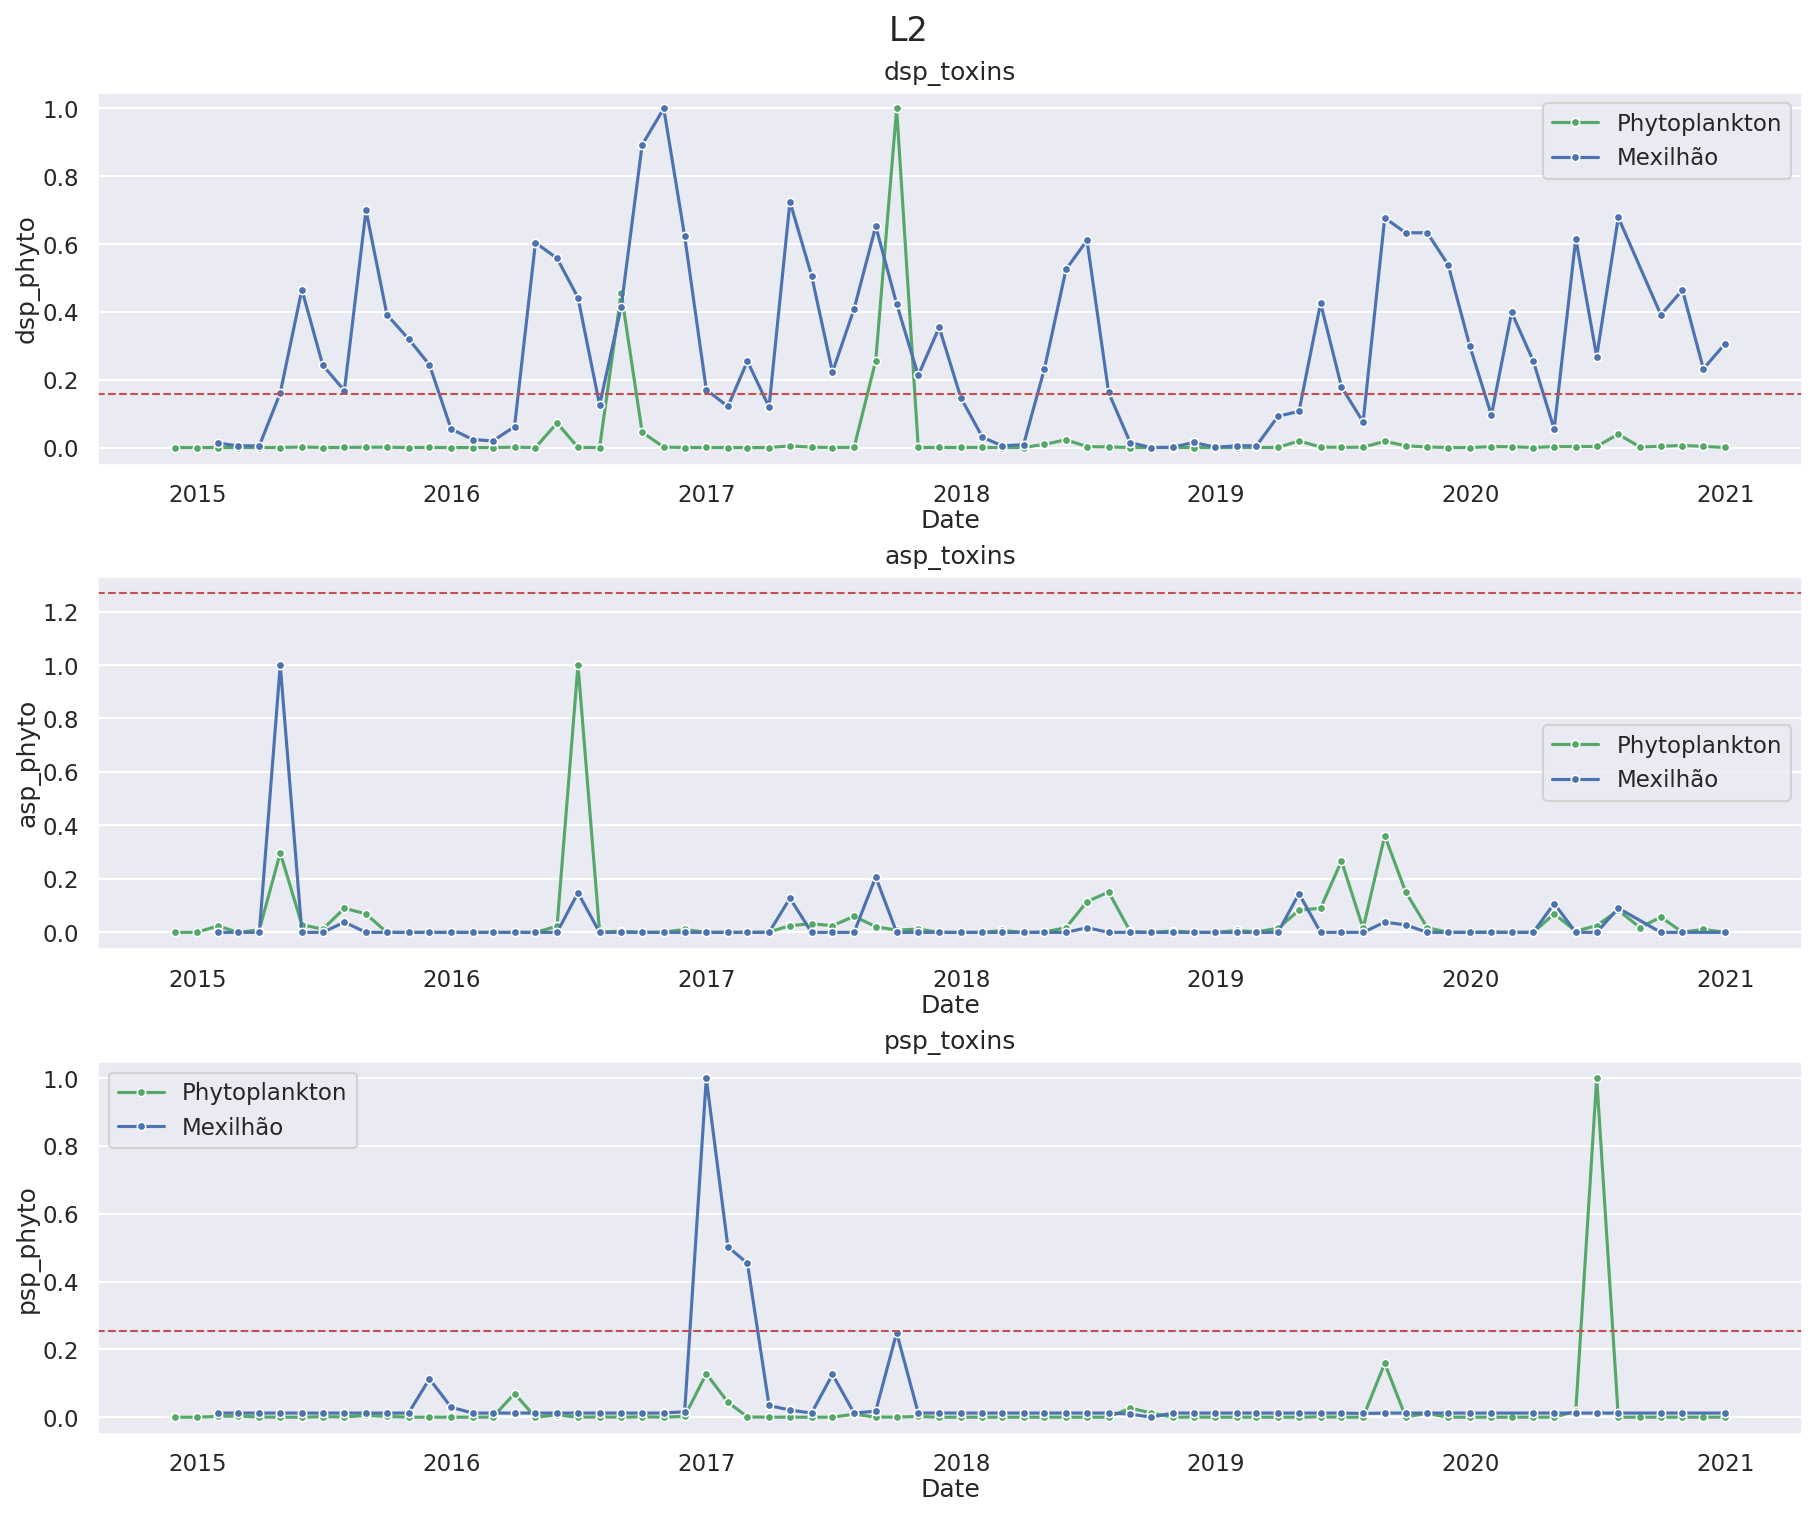

####################################################################################################


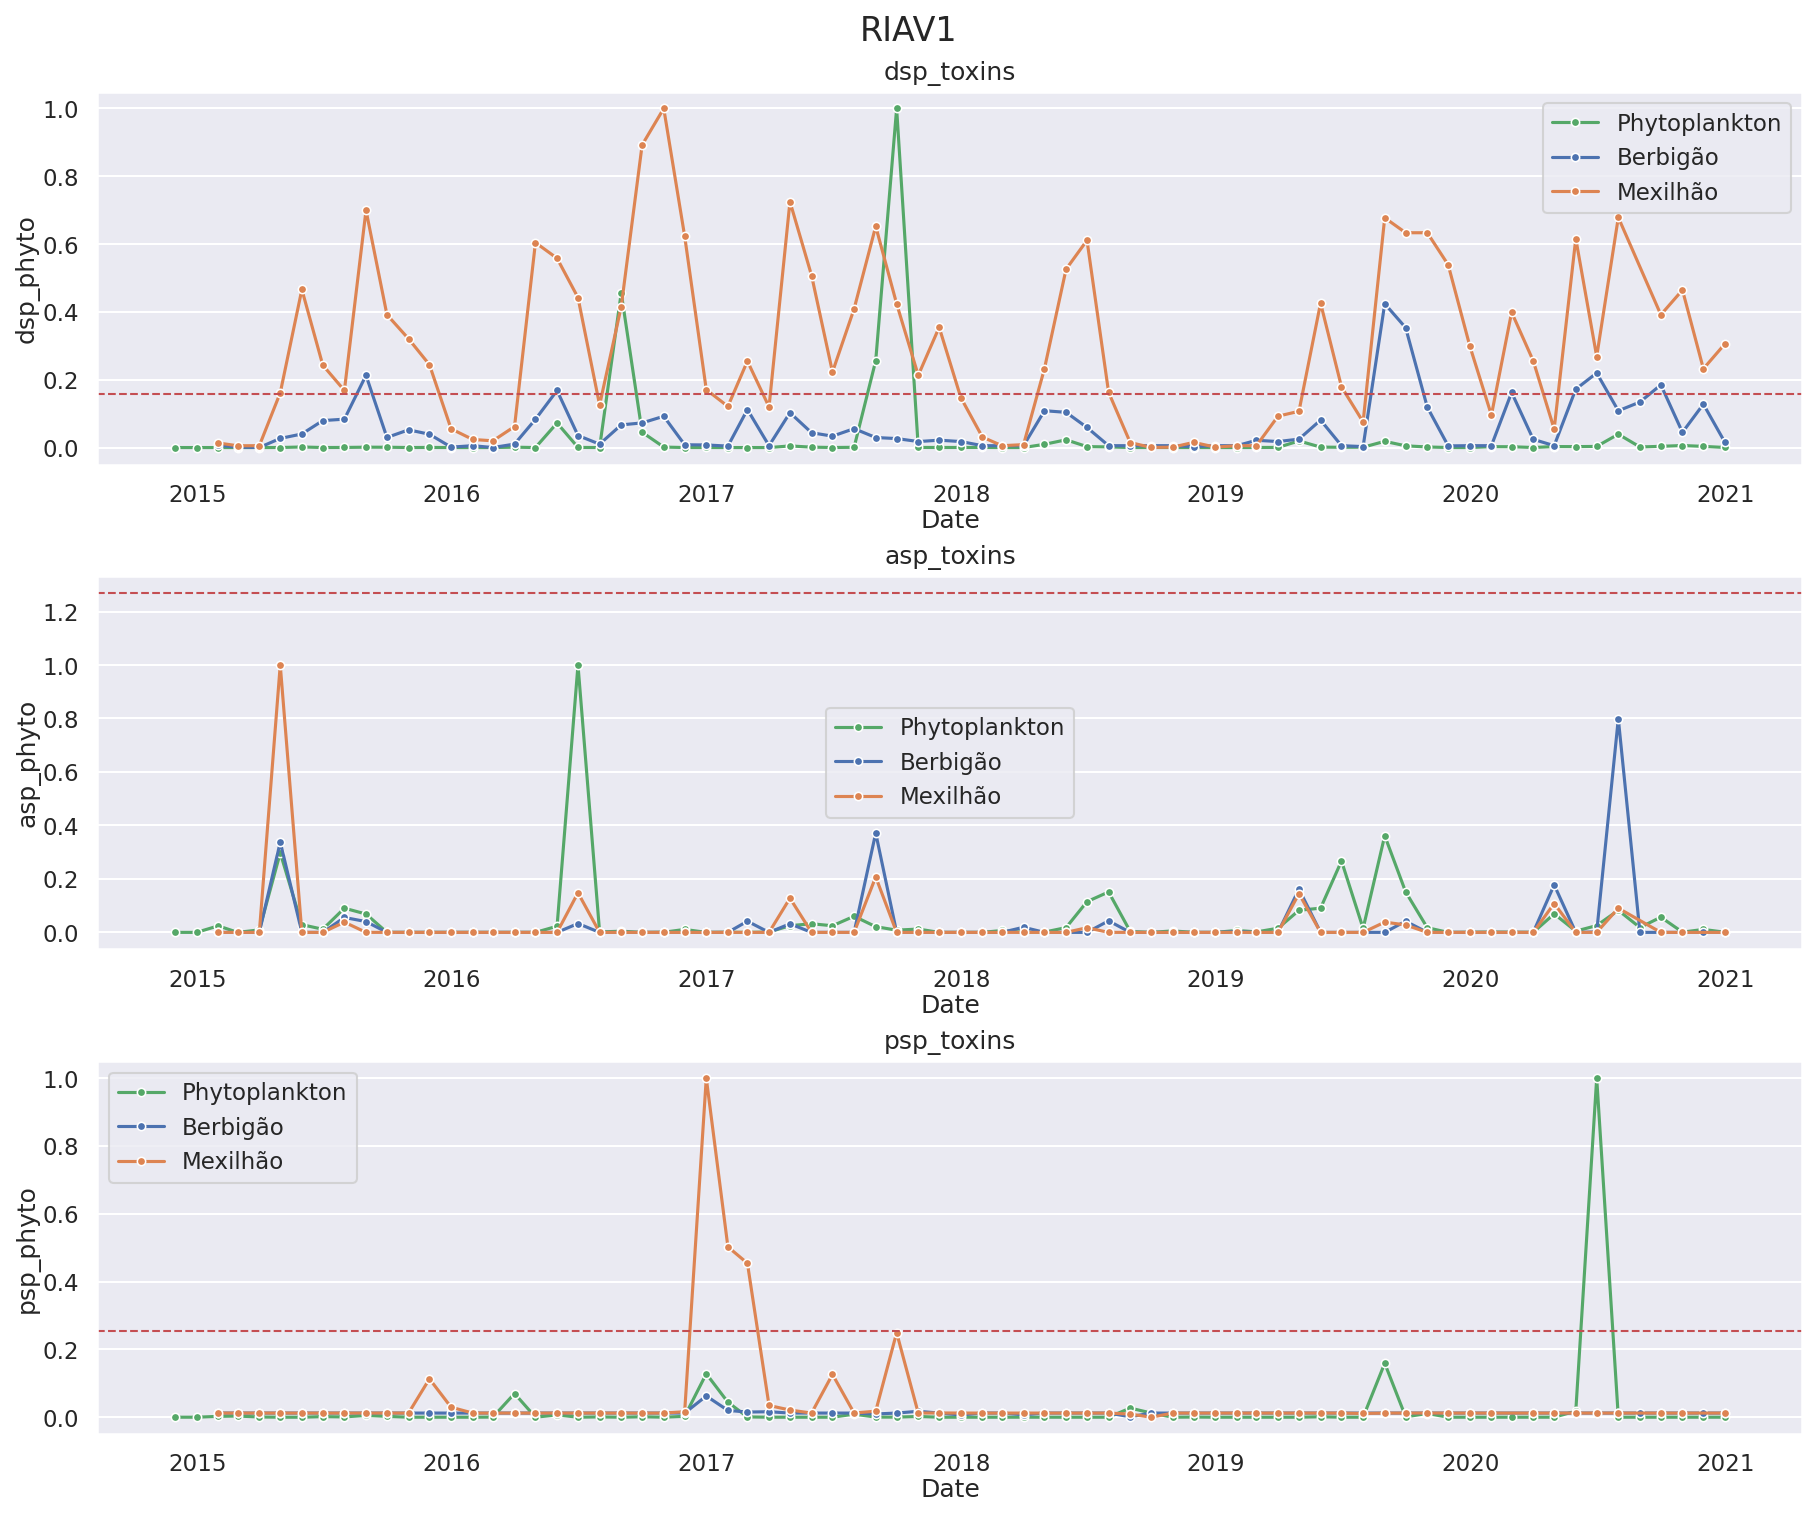

####################################################################################################


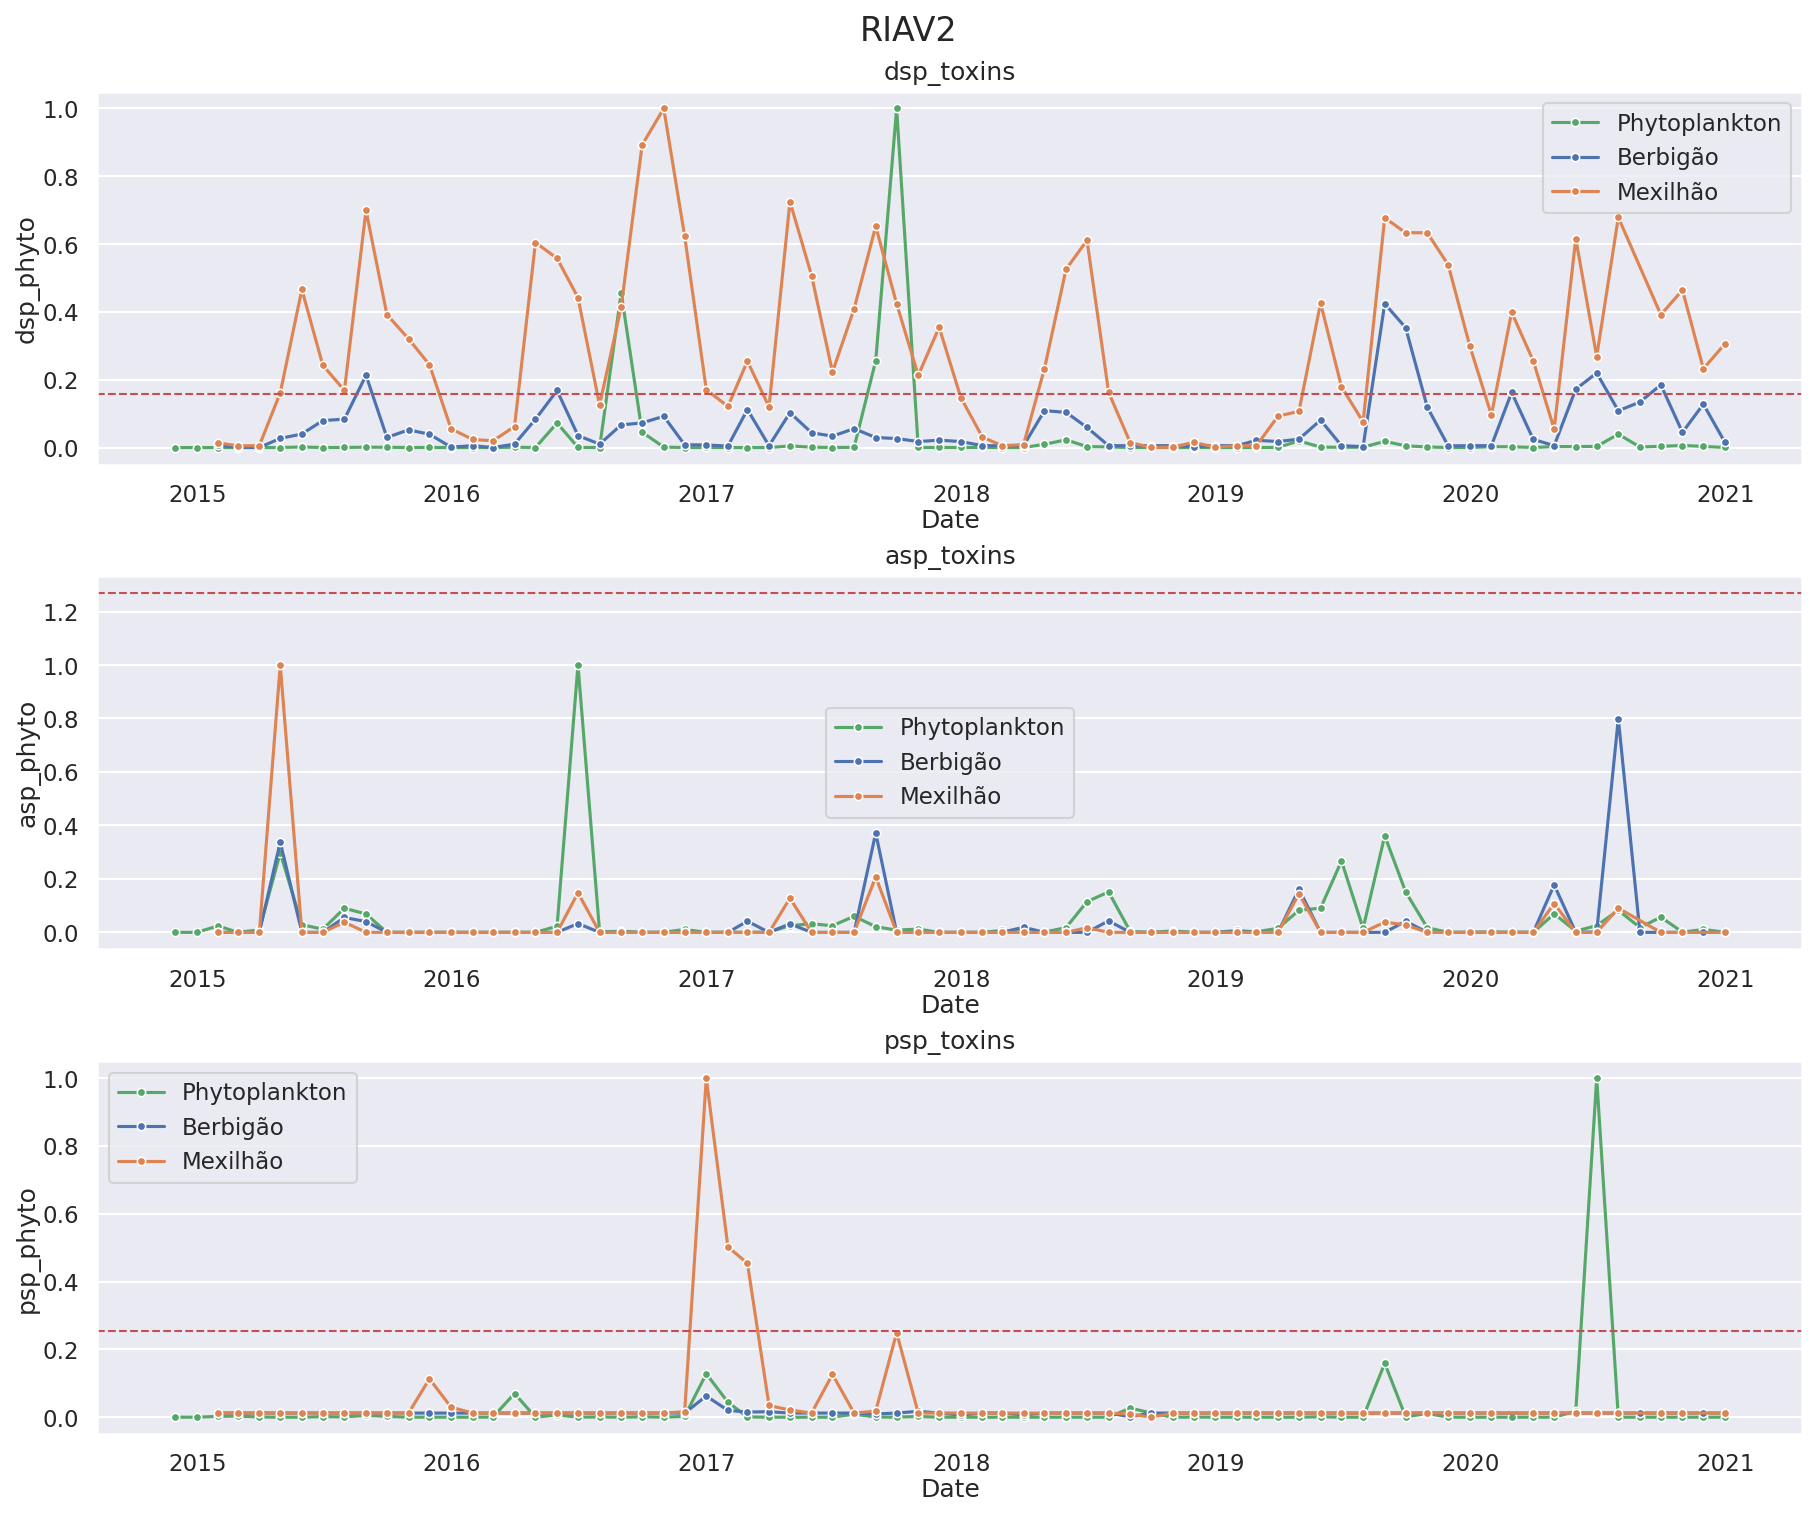

####################################################################################################


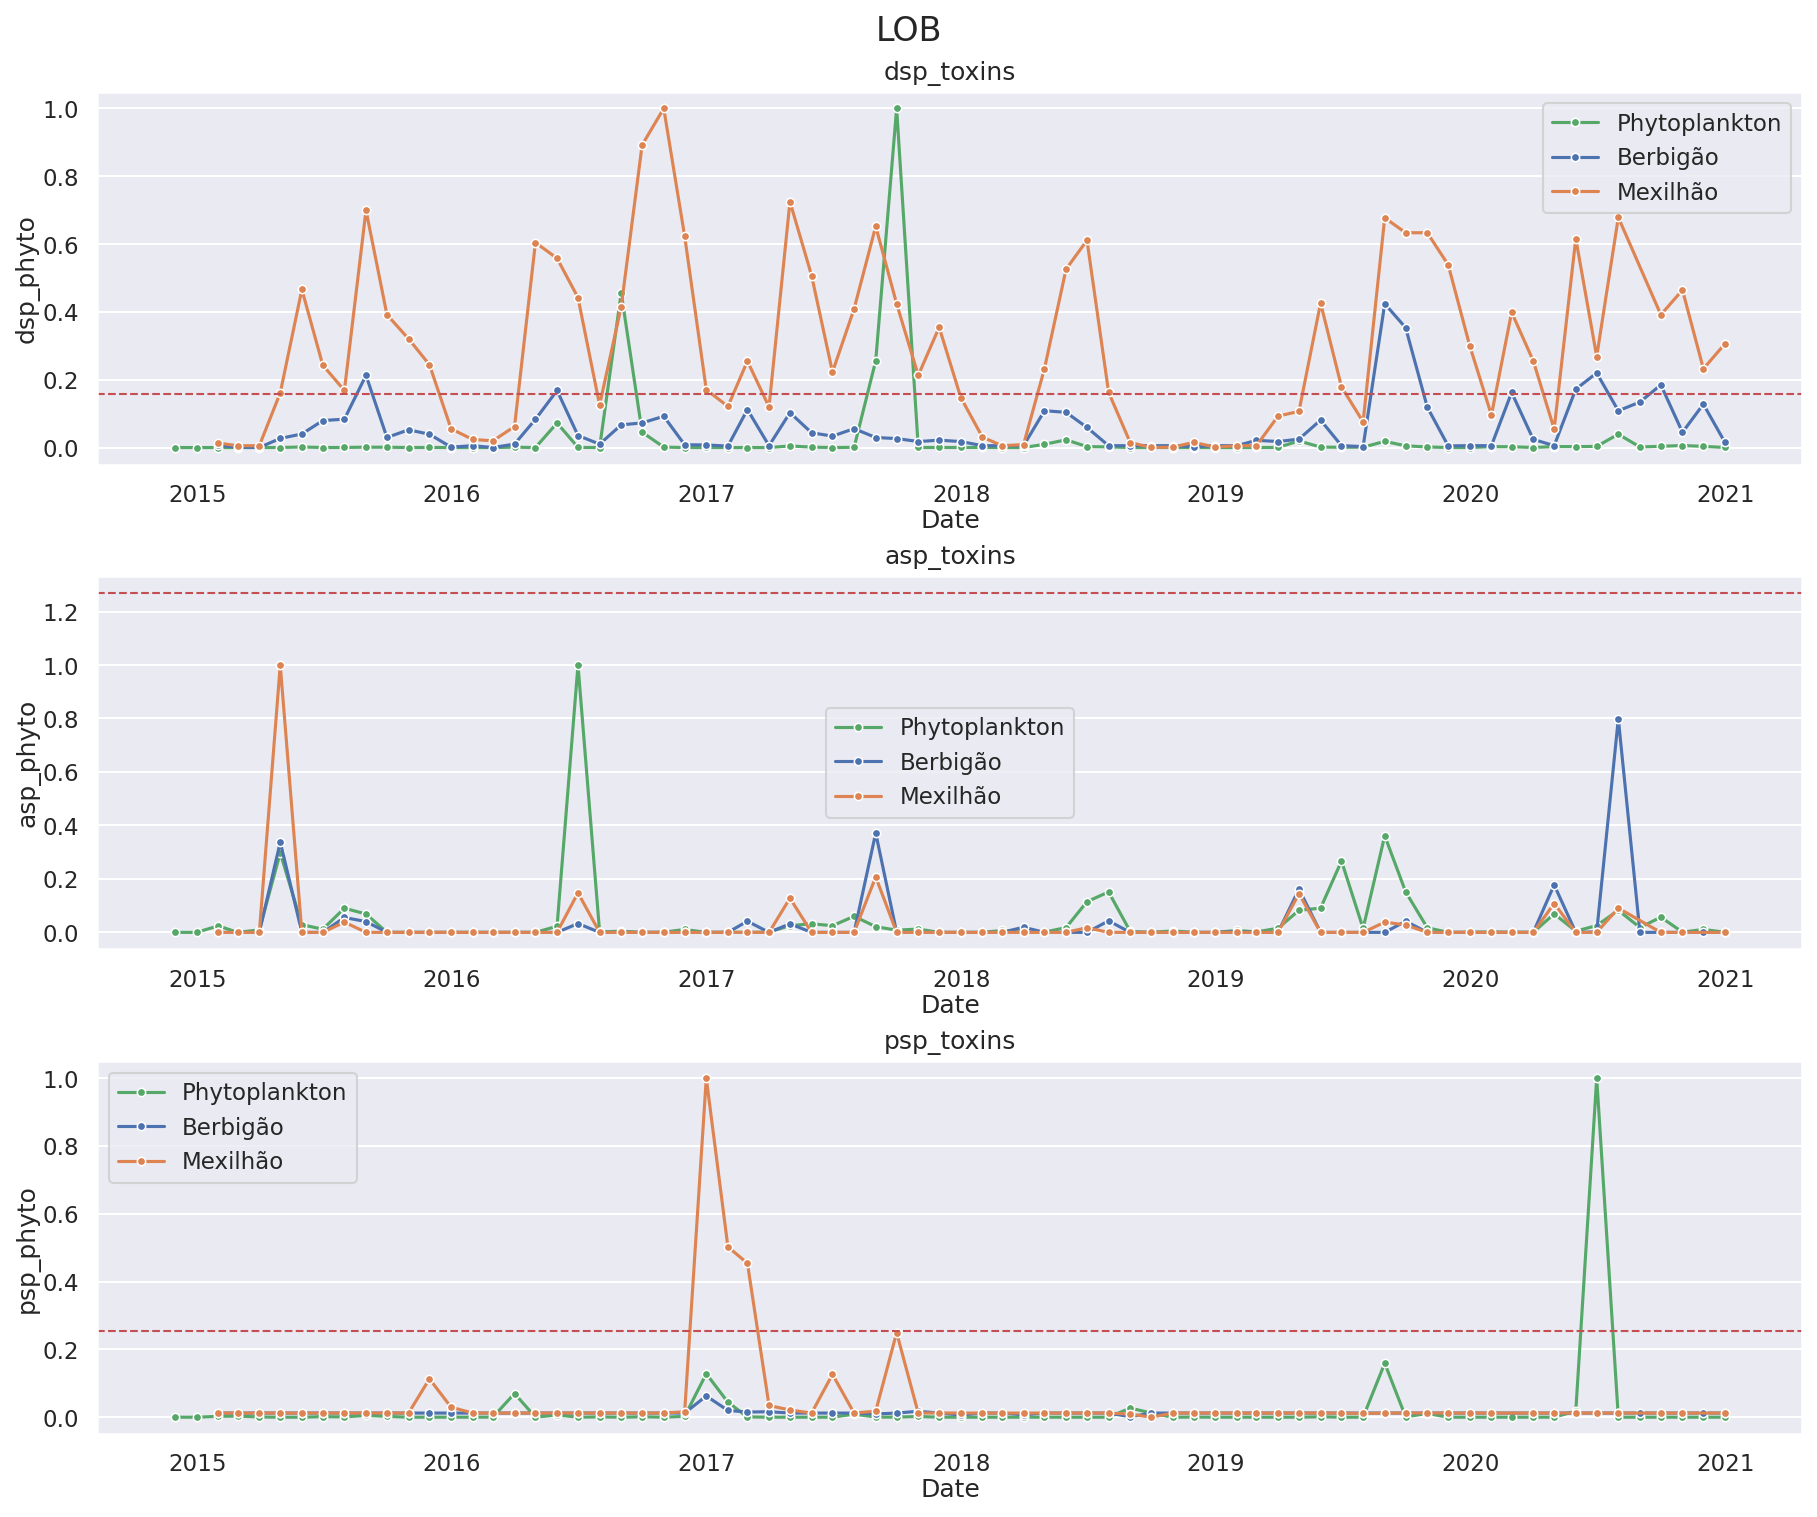

####################################################################################################


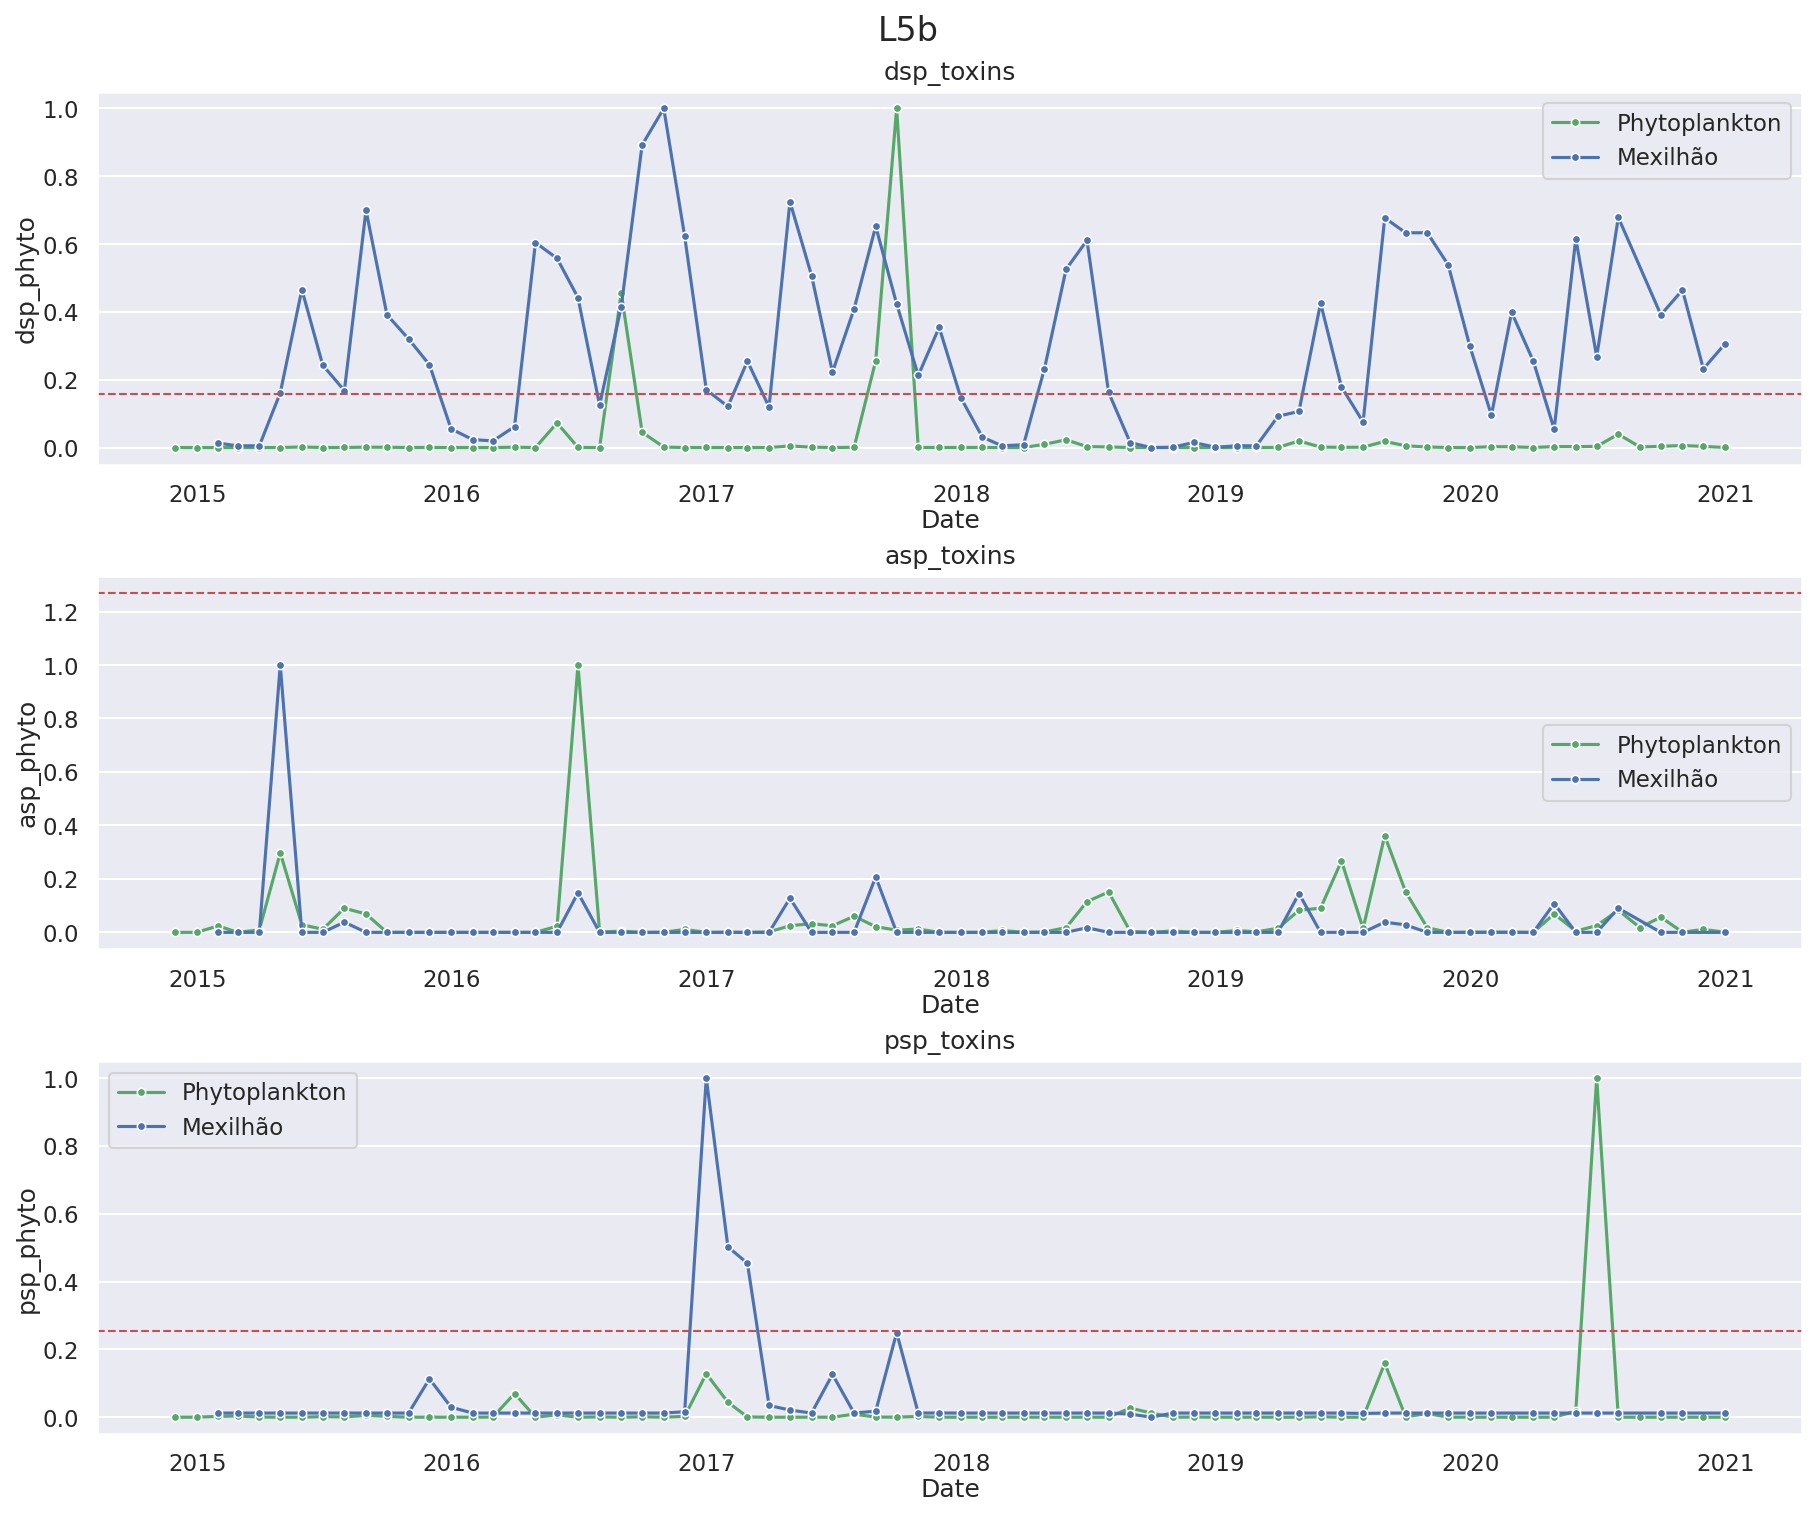

####################################################################################################


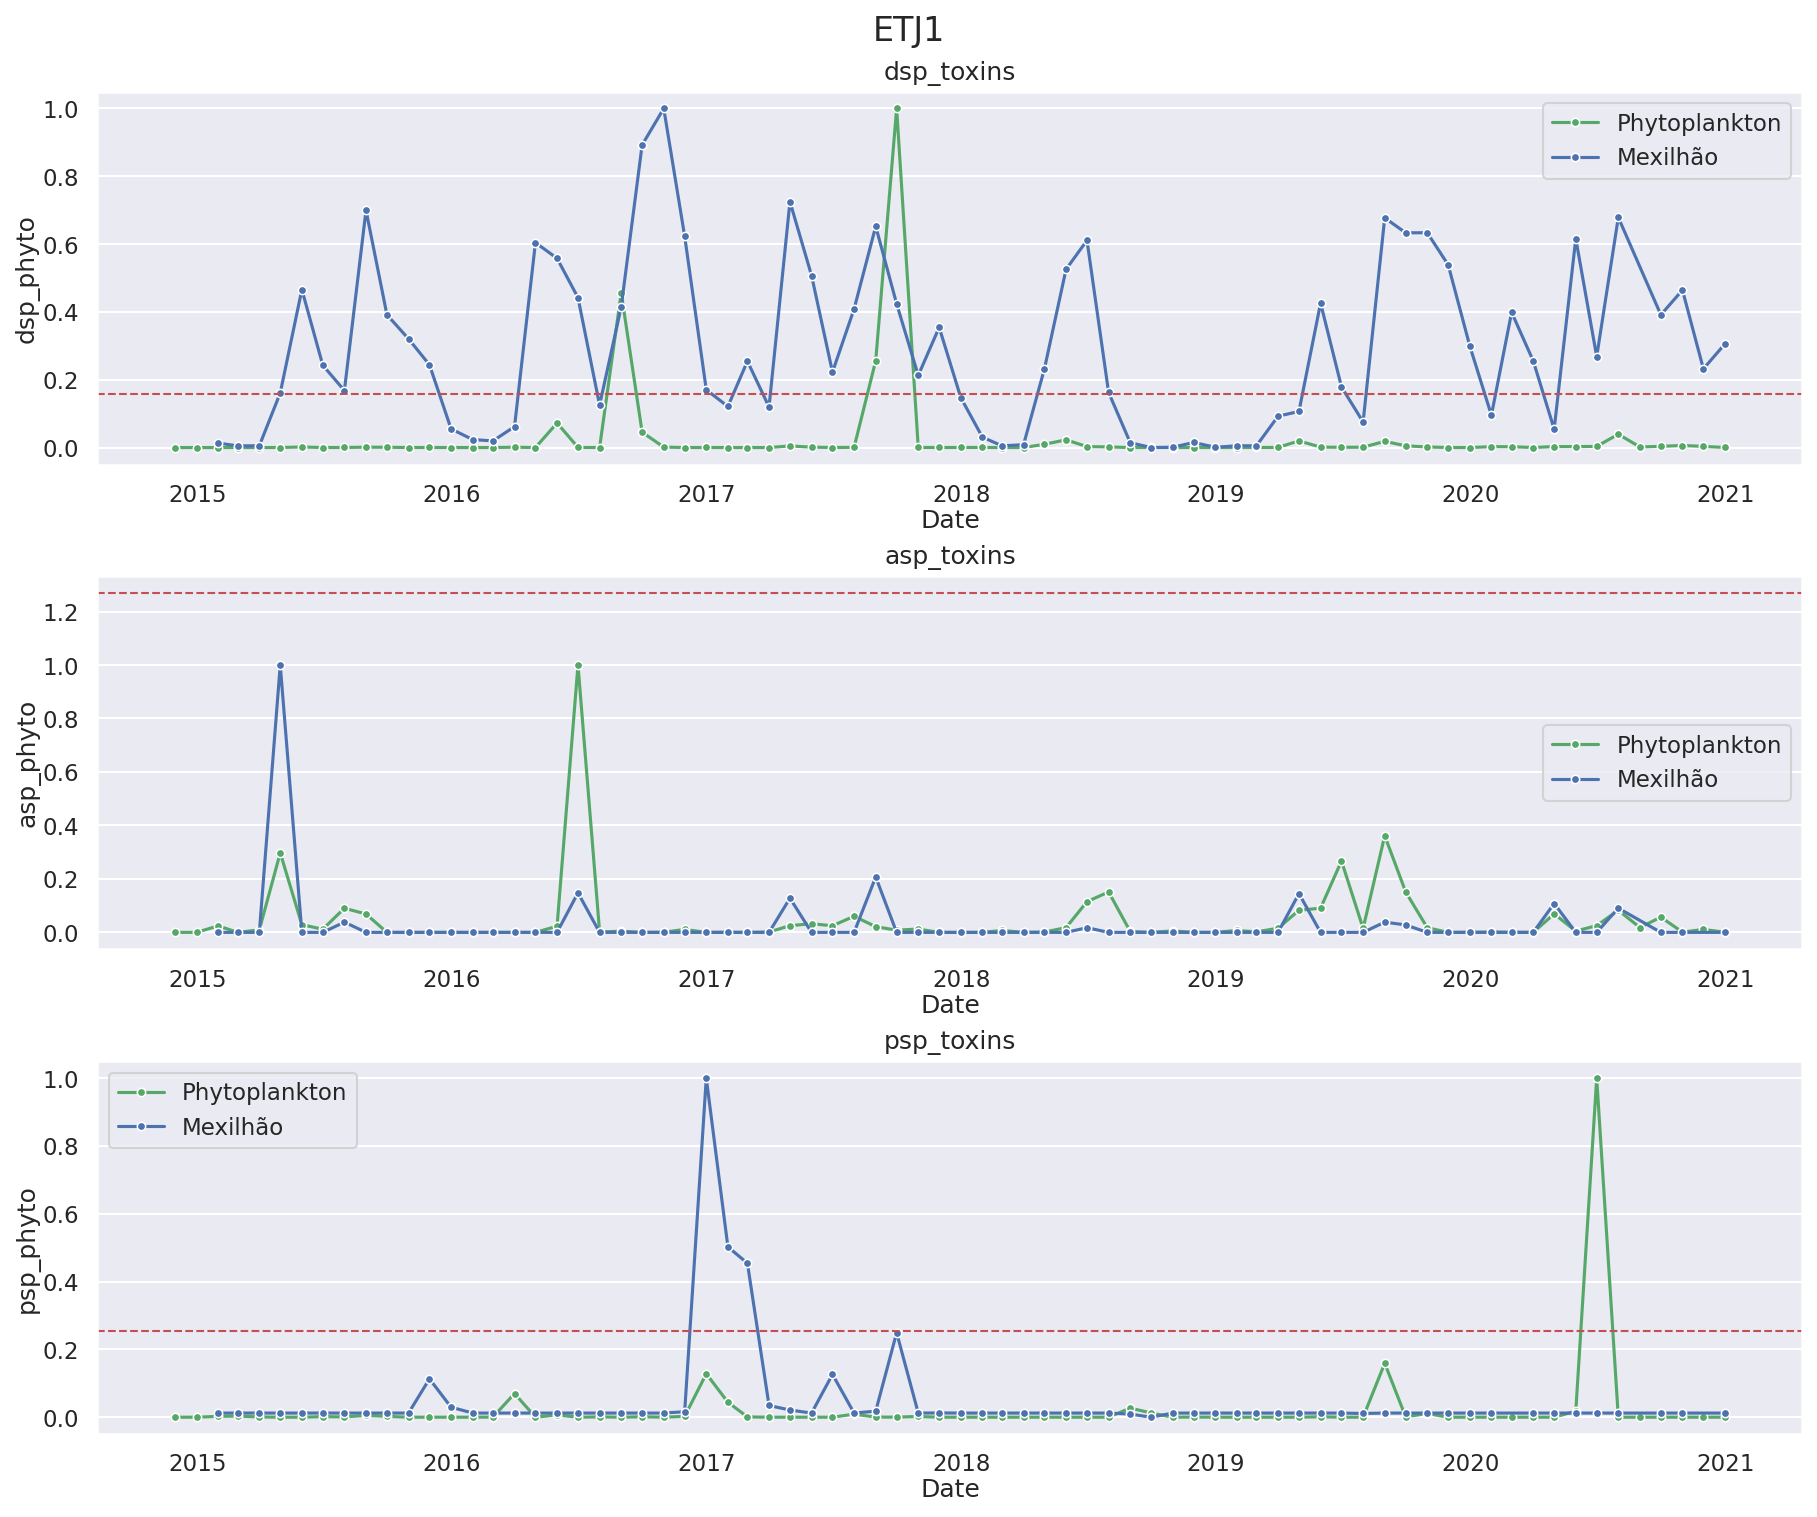

####################################################################################################


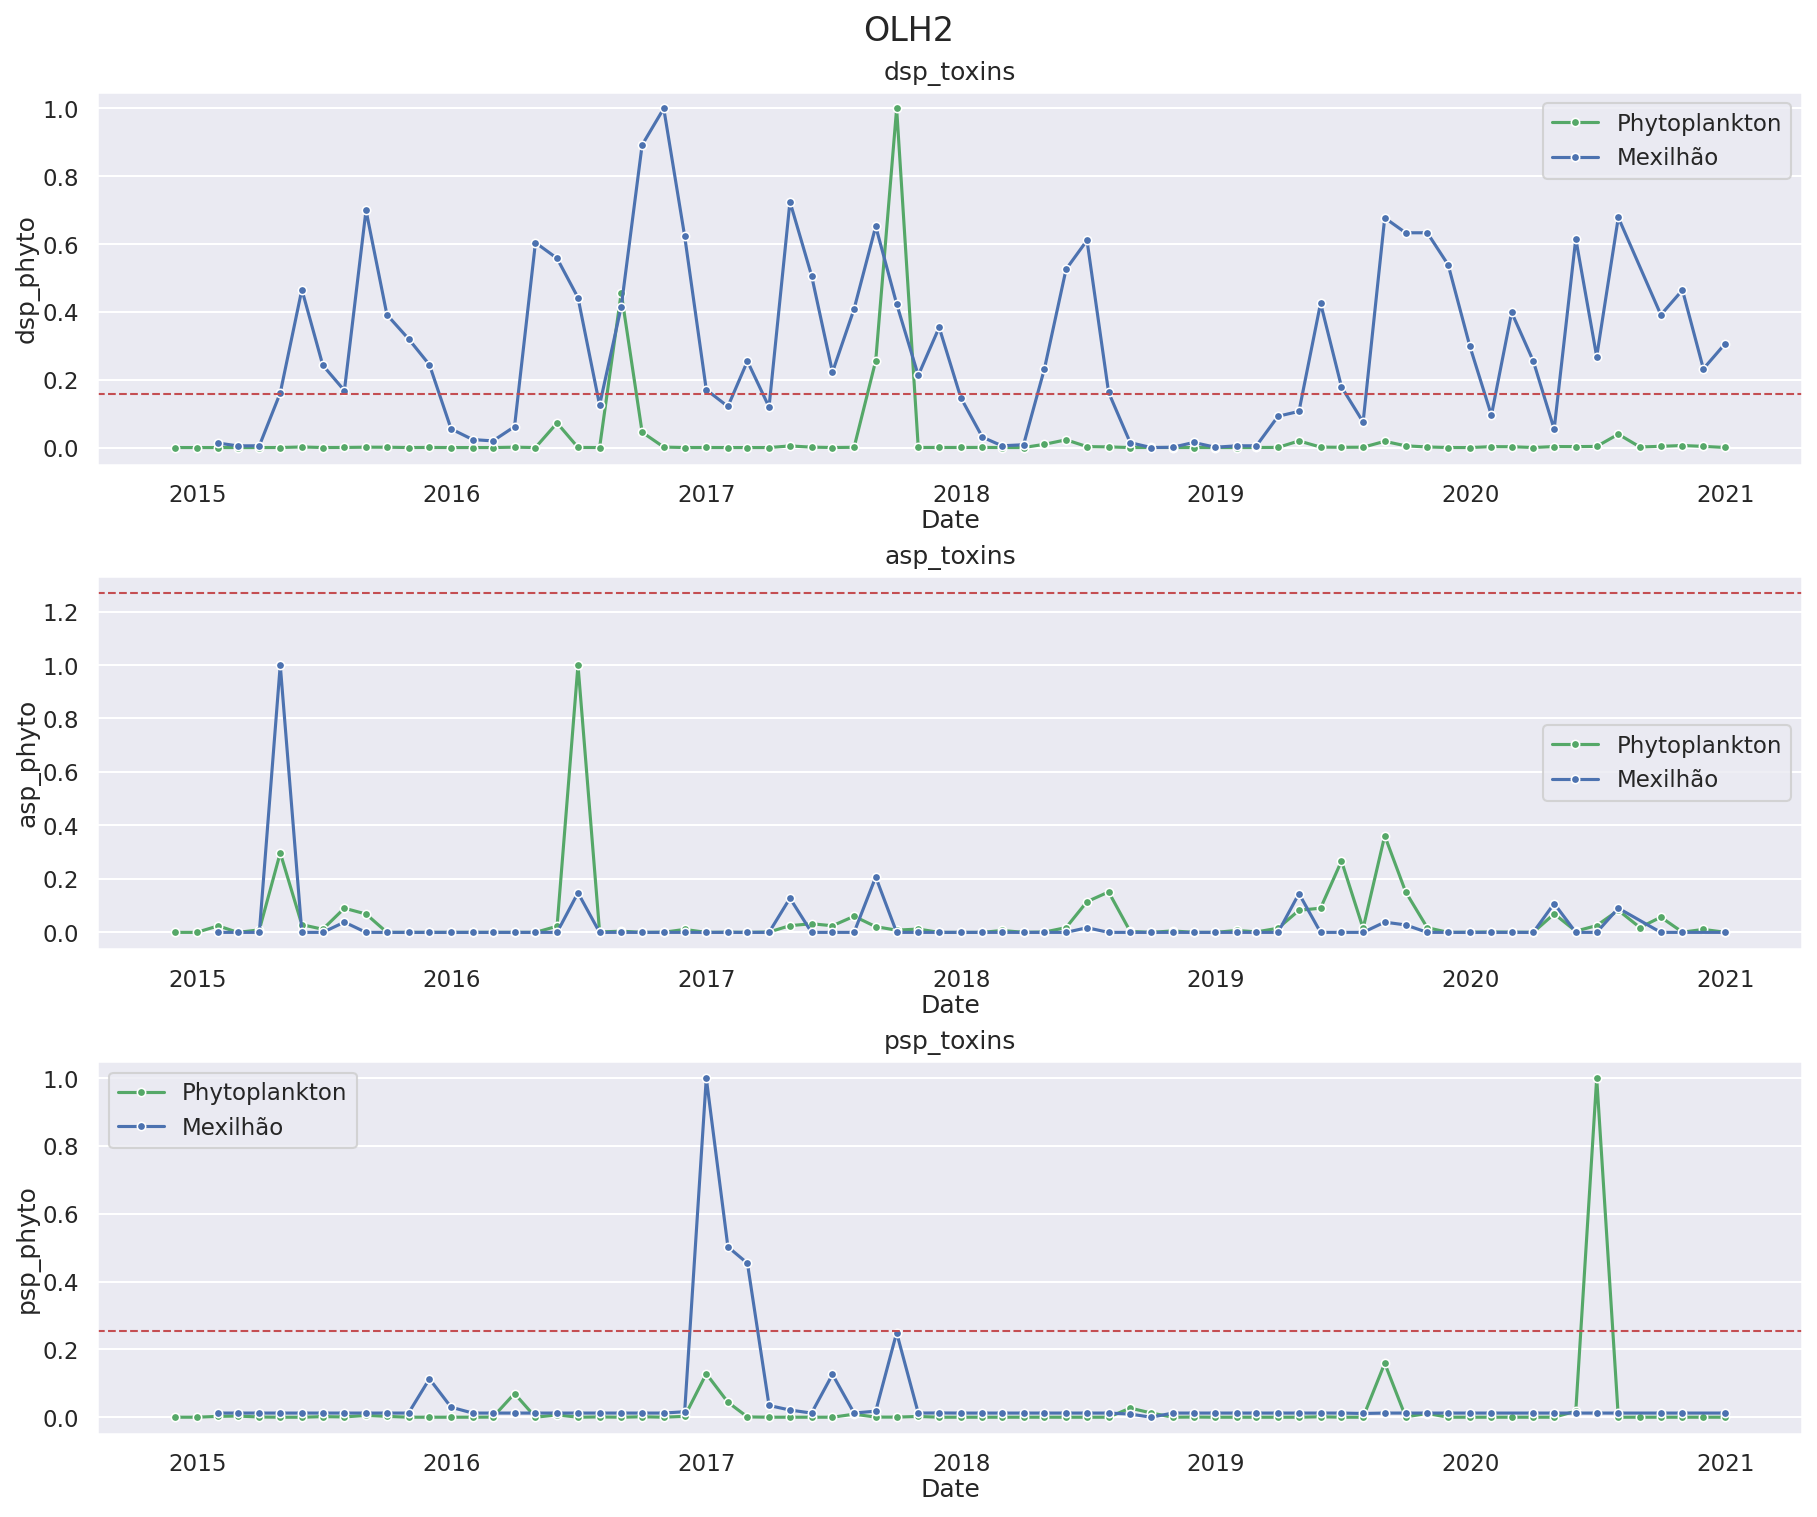

####################################################################################################


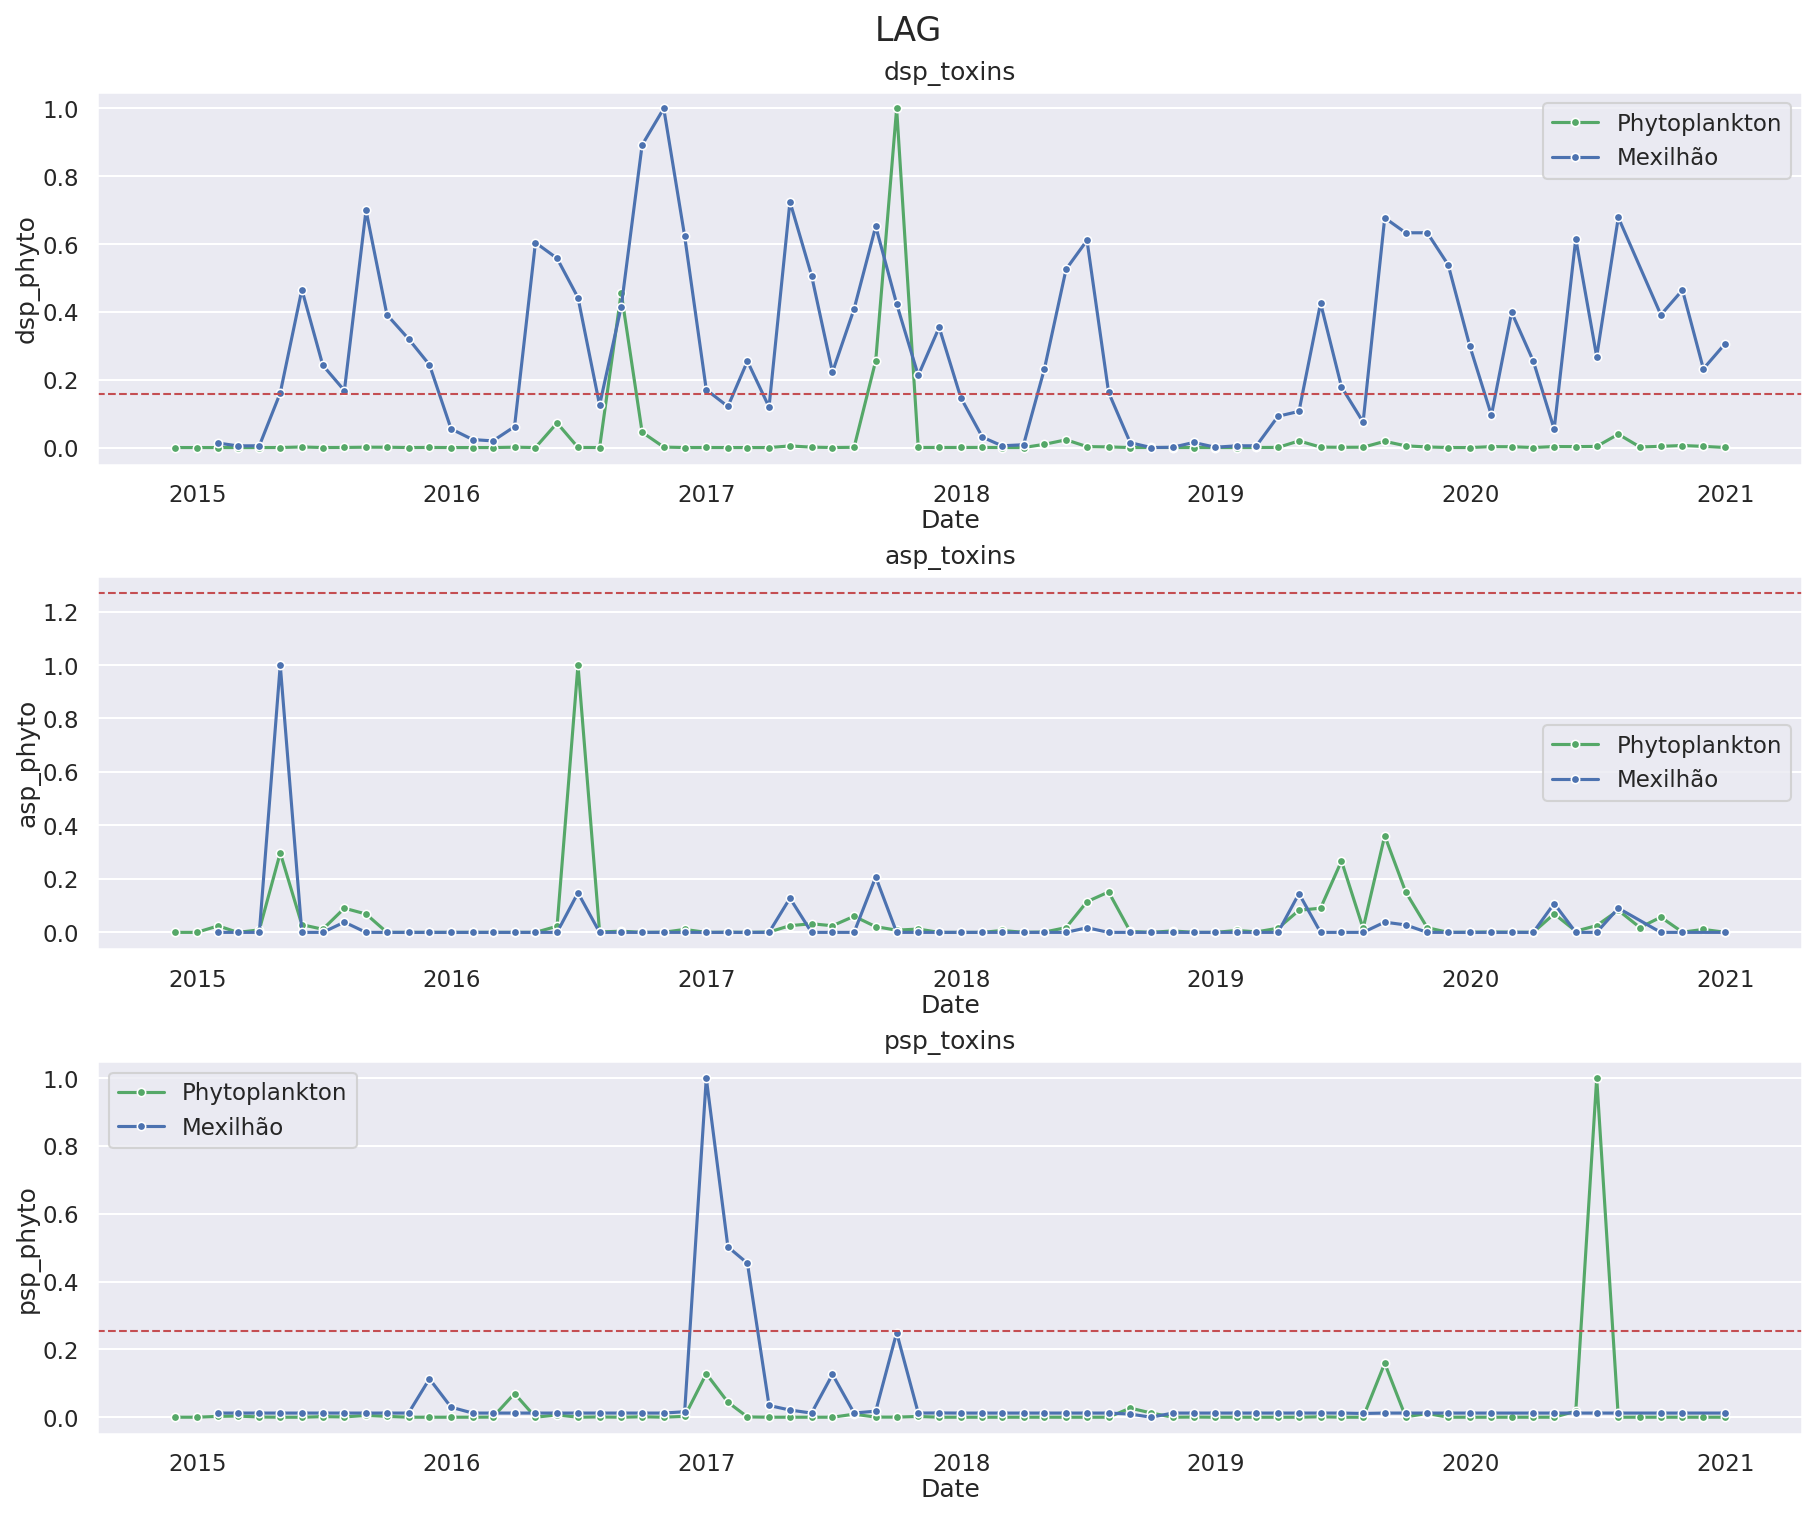

####################################################################################################


In [82]:
by="M"
for a in areas_to_inspect:
    fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
    fig.suptitle(a, fontsize=16)
    species = areas_to_inspect[a]
    ax[0] = compare_phyto_toxicity(biotoxins_ts, phyto_ts, area, species, "dsp_toxins", by, ax[0], 160)
    ax[1] = compare_phyto_toxicity(biotoxins_ts, phyto_ts, area, species, "asp_toxins", by, ax[1], 20)
    ax[2] = compare_phyto_toxicity(biotoxins_ts, phyto_ts, area, species, "psp_toxins", by, ax[2], 800)
    plt.show()
    print("#"*100)

# RIAV1

In [49]:
area = "RIAV1"
species = ["Mexilhão", "Berbigão"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão                  308
Mexilhão                  293
Amêijoa-macha              90
Longueirão                 73
Amêijoa-japonesa           66
Amêijoa-boa                59
Ostra-japonesa/gigante     40
Ostra                       1
Name: Species, dtype: int64

In [50]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W", plot=False)
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M", plot=False)

ts_week_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "W", plot=False)
ts_month_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "M", plot=False)

## Compare species and phyto

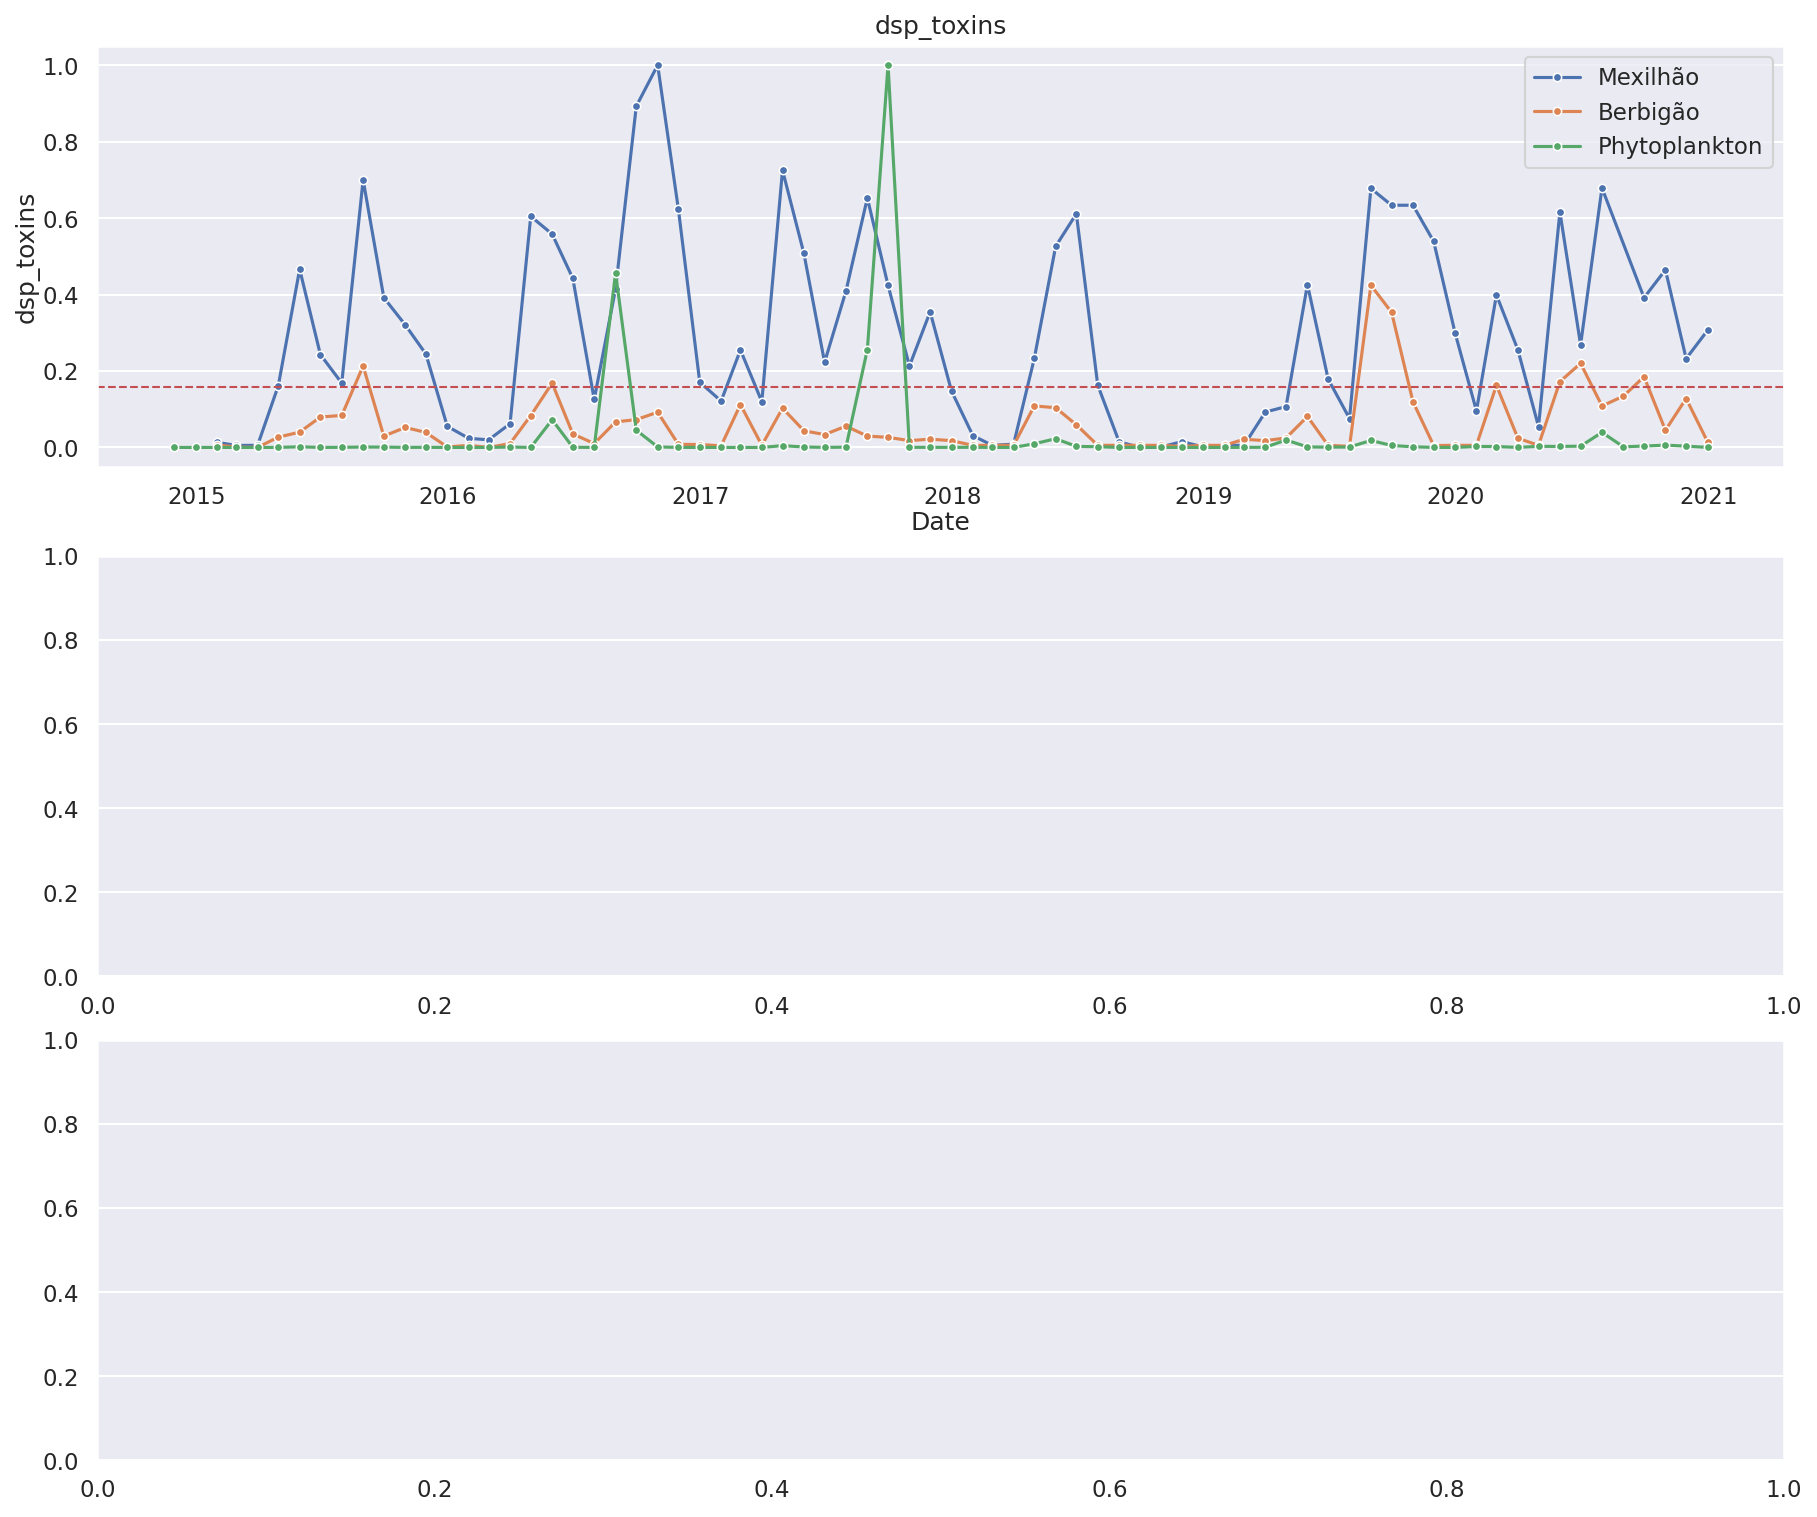

In [47]:
by="M"
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_phyto_toxicity(biotoxins_ts, phyto_ts, area, species, "dsp_toxins", by, ax[0], 160)
plt.show()

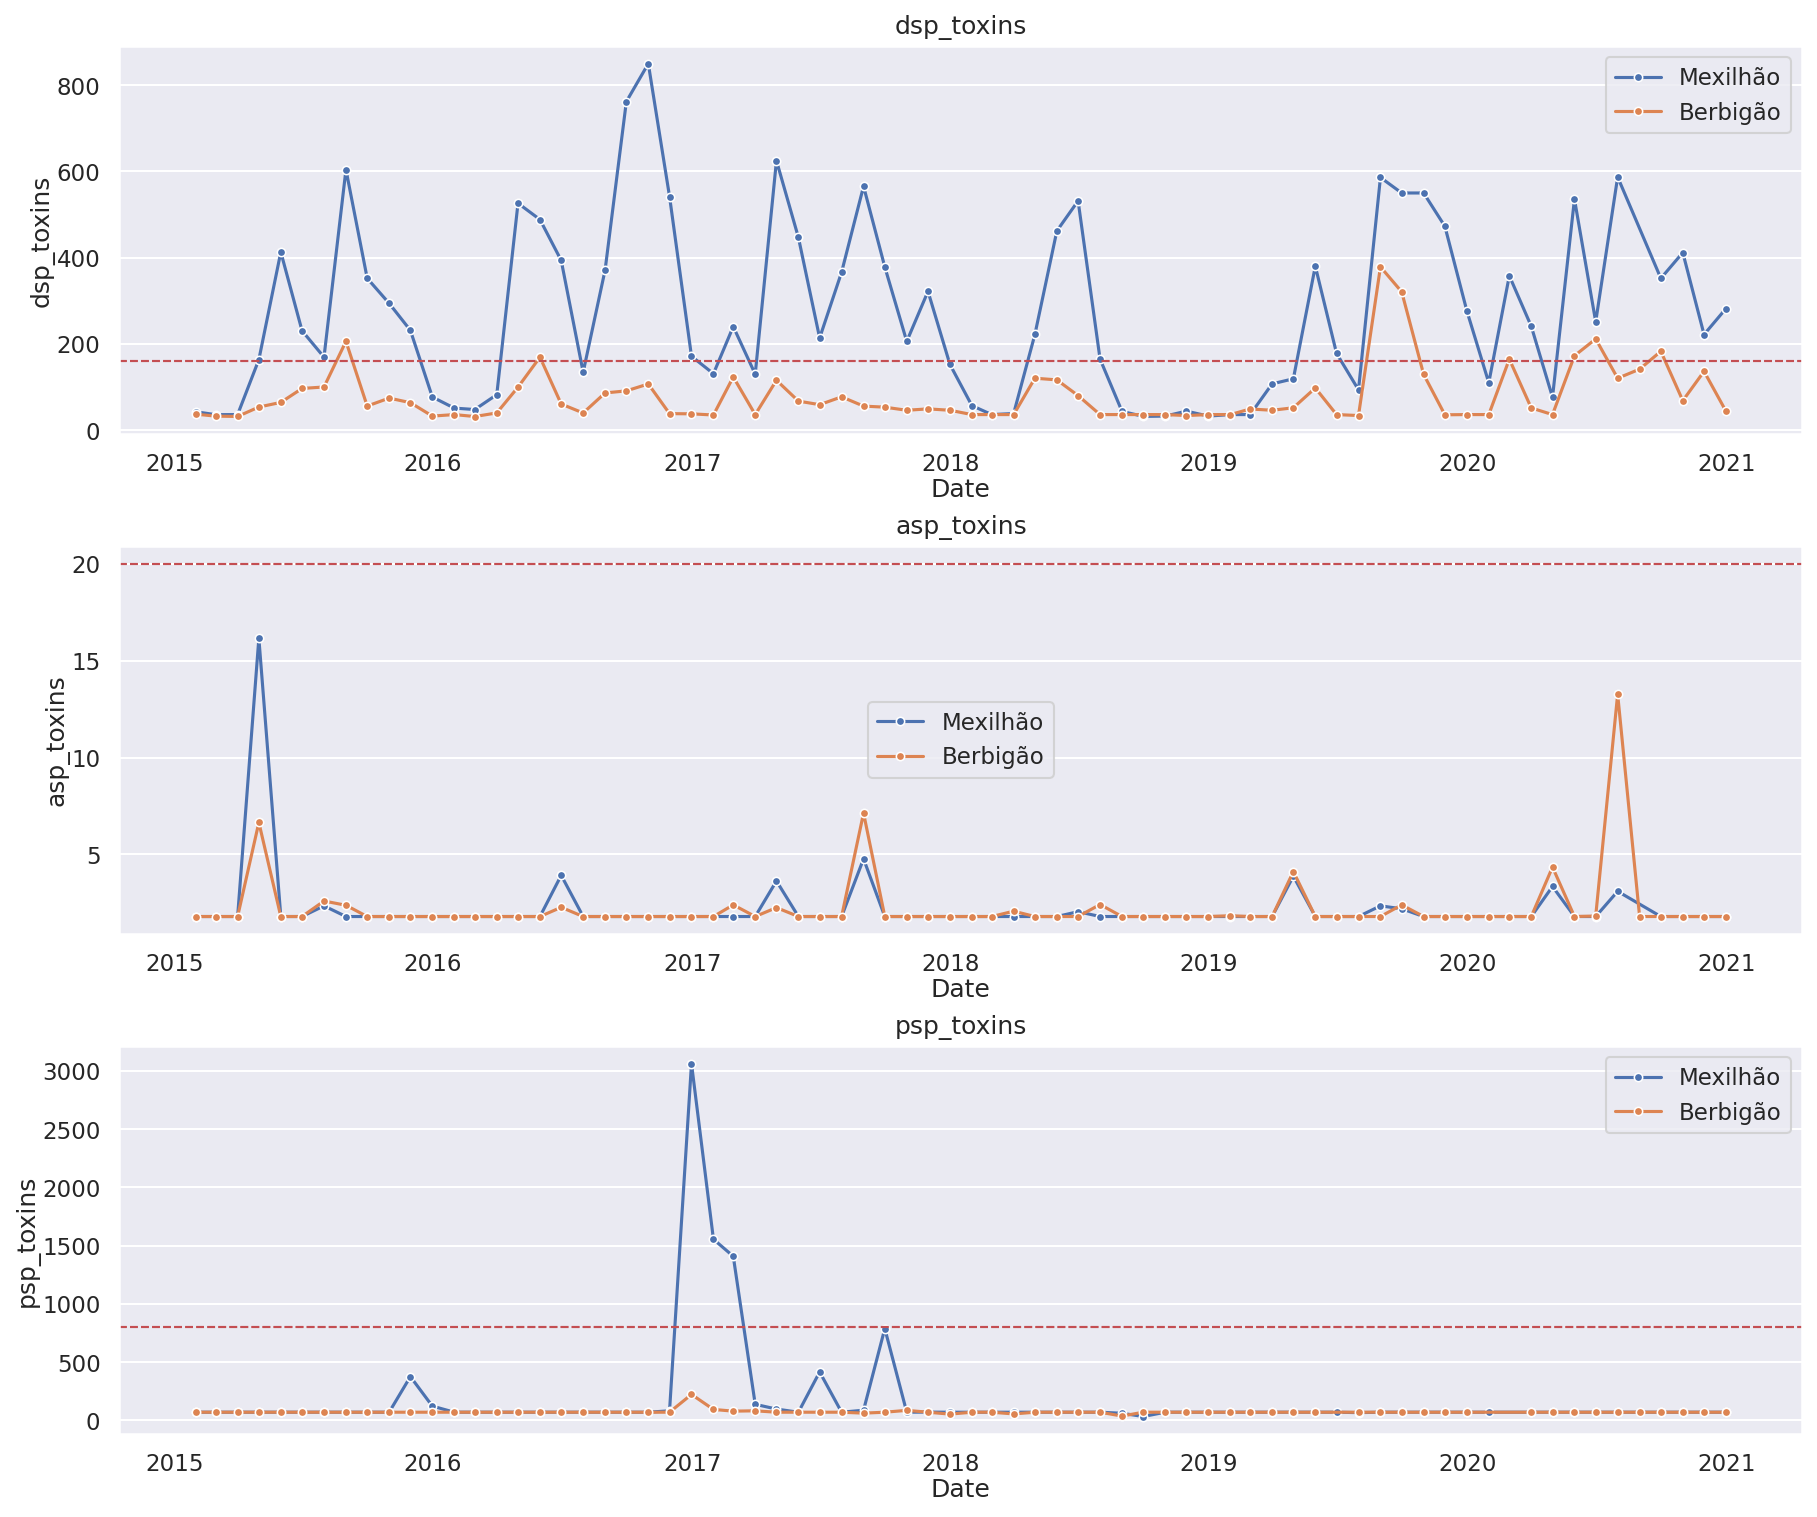

In [9]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

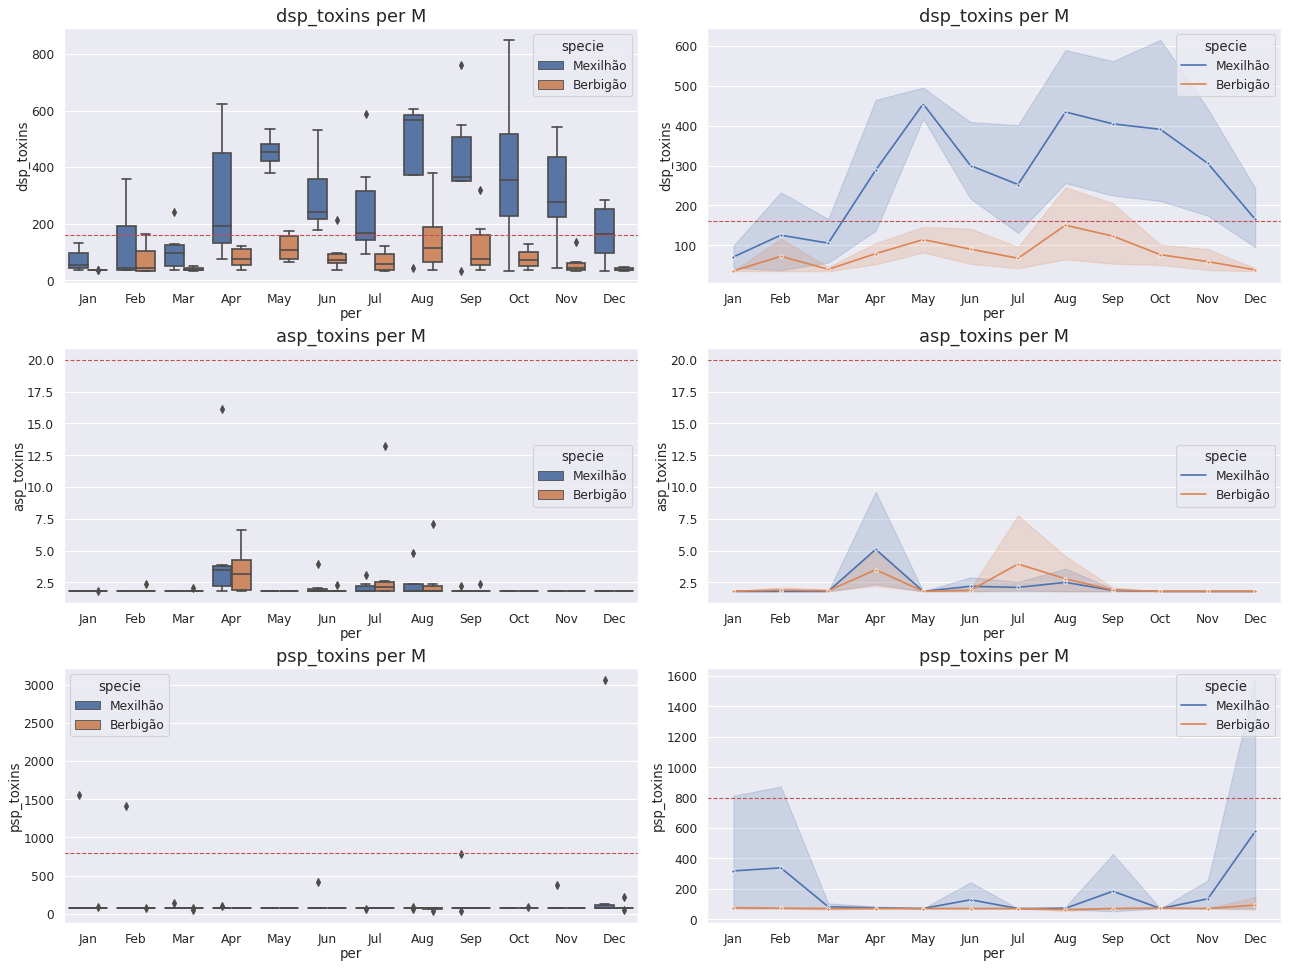

In [10]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

## Trend

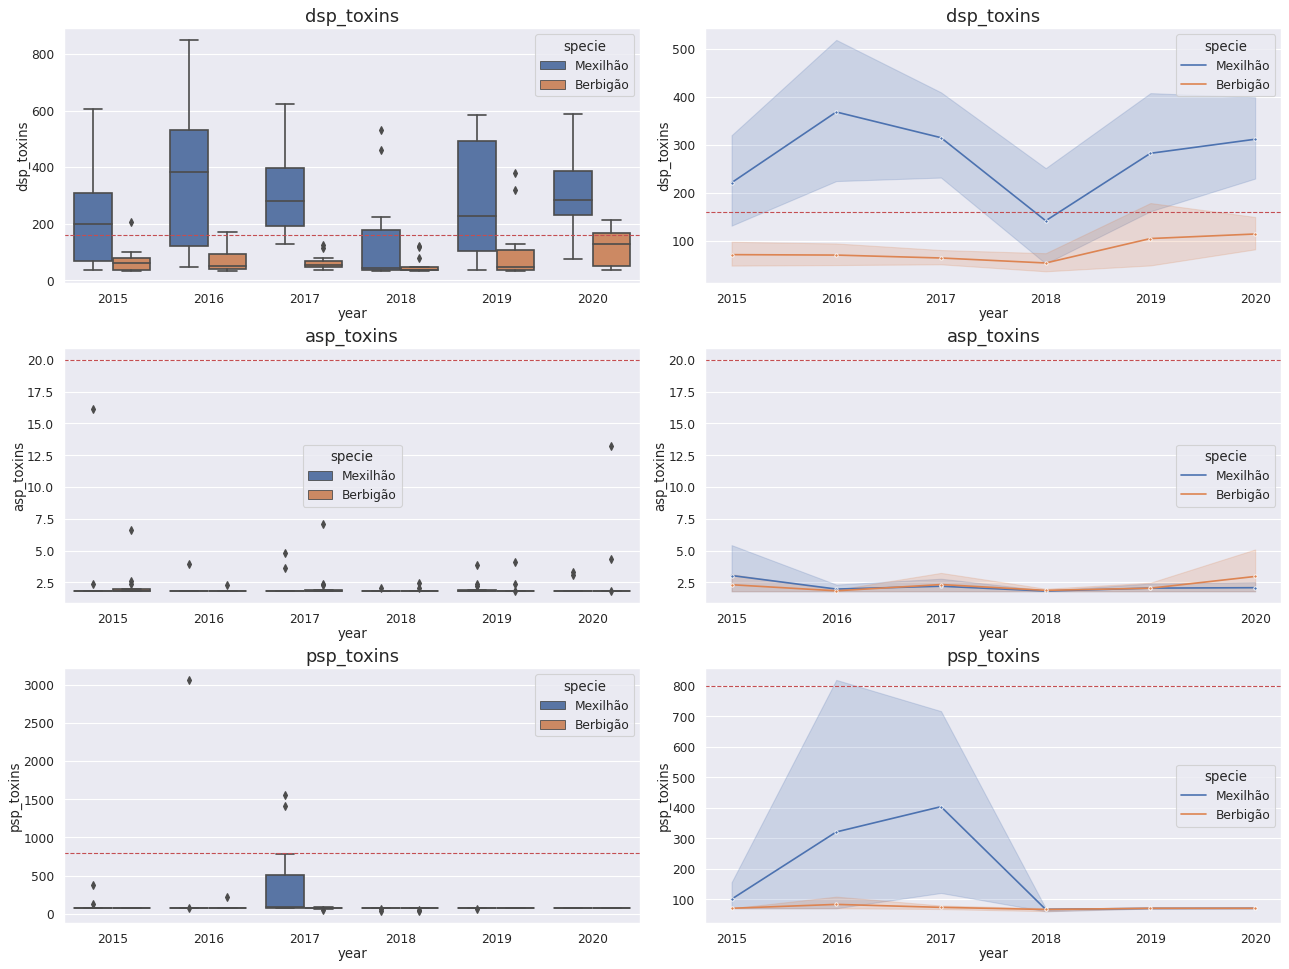

In [11]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

# L2

In [20]:
area = "L2"
species = ["Mexilhão", "Amêijoa-branca"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Mexilhão           251
Amêijoa-branca     240
Castanhola          42
Amêijoa-relógio     12
Telina               5
Pé-de-burrinho       1
Lapa                 1
Name: Species, dtype: int64

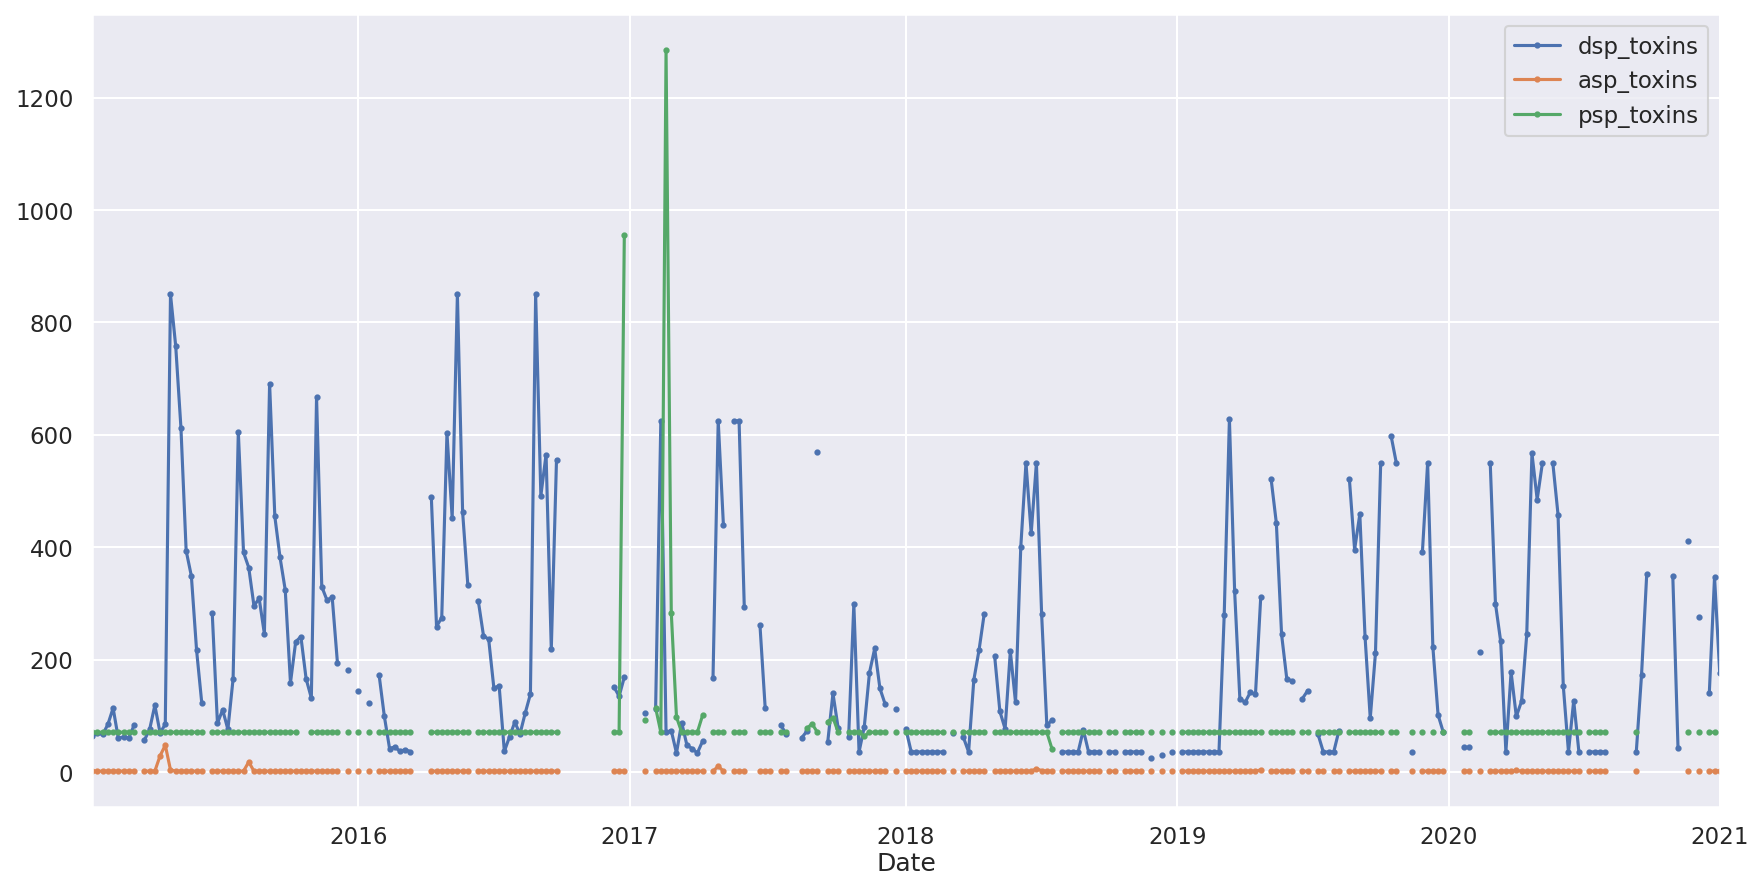

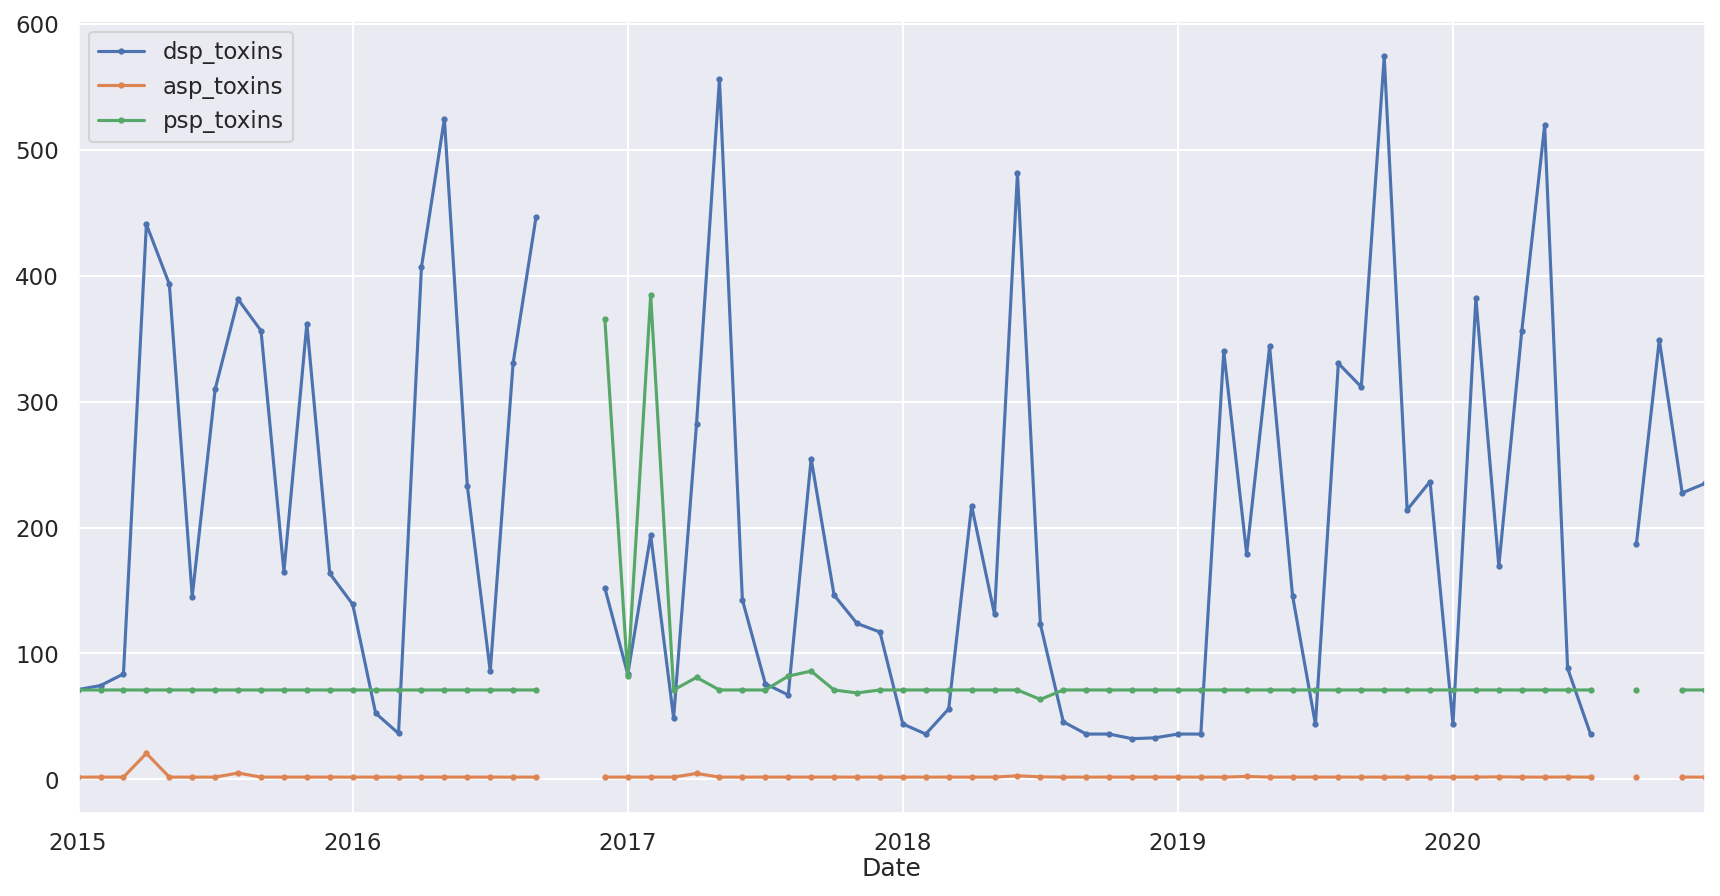

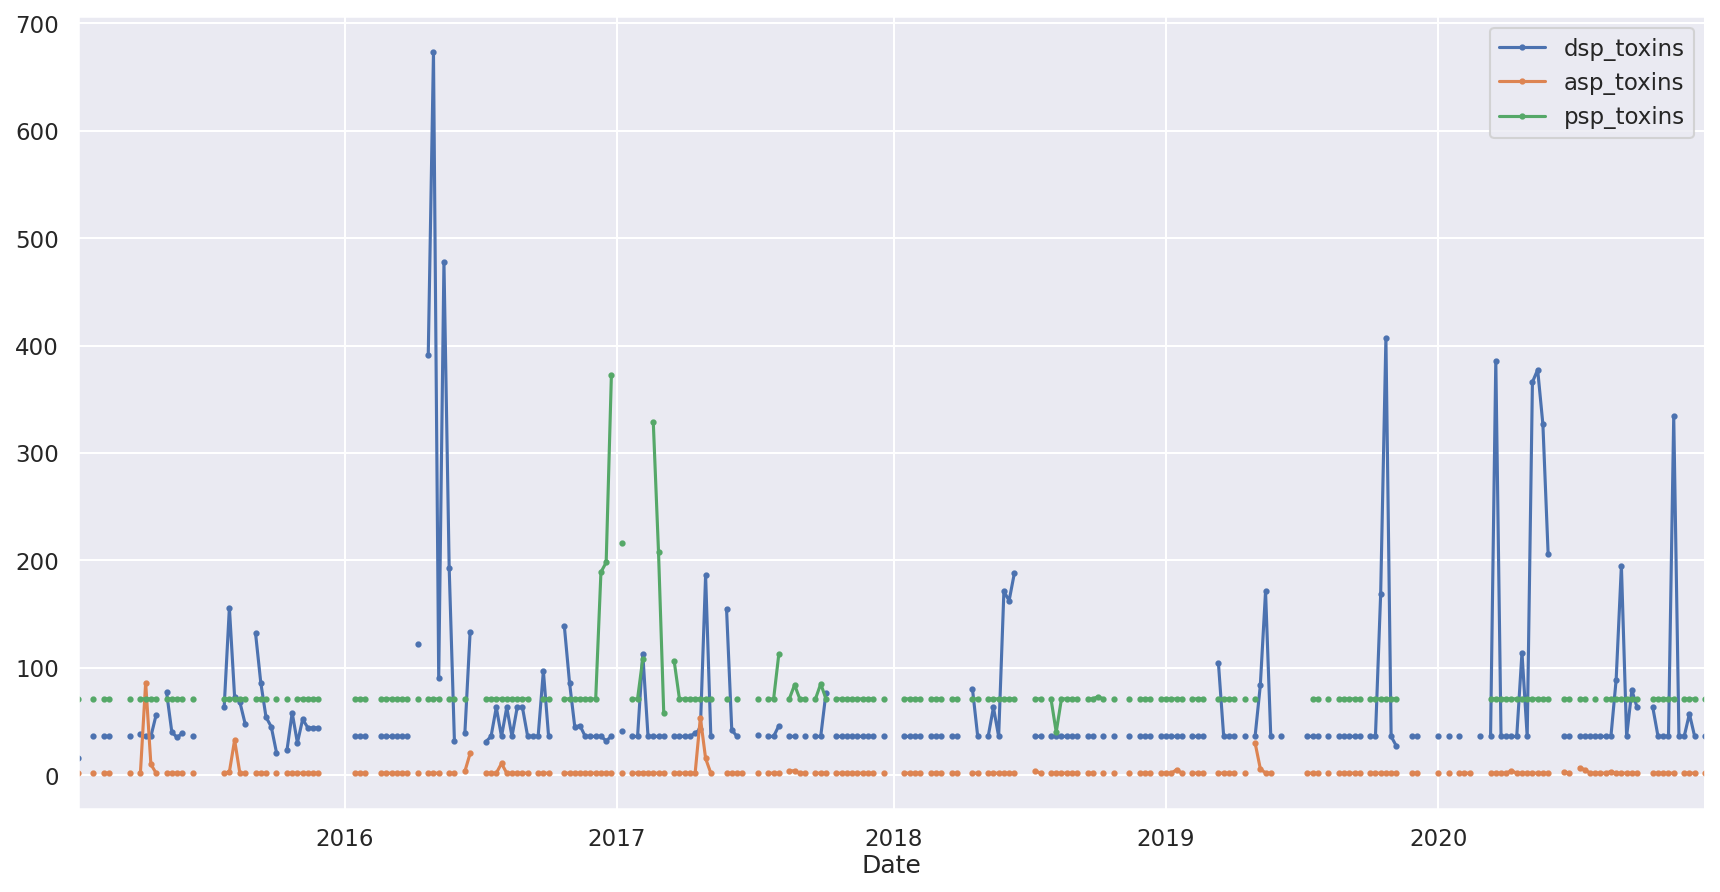

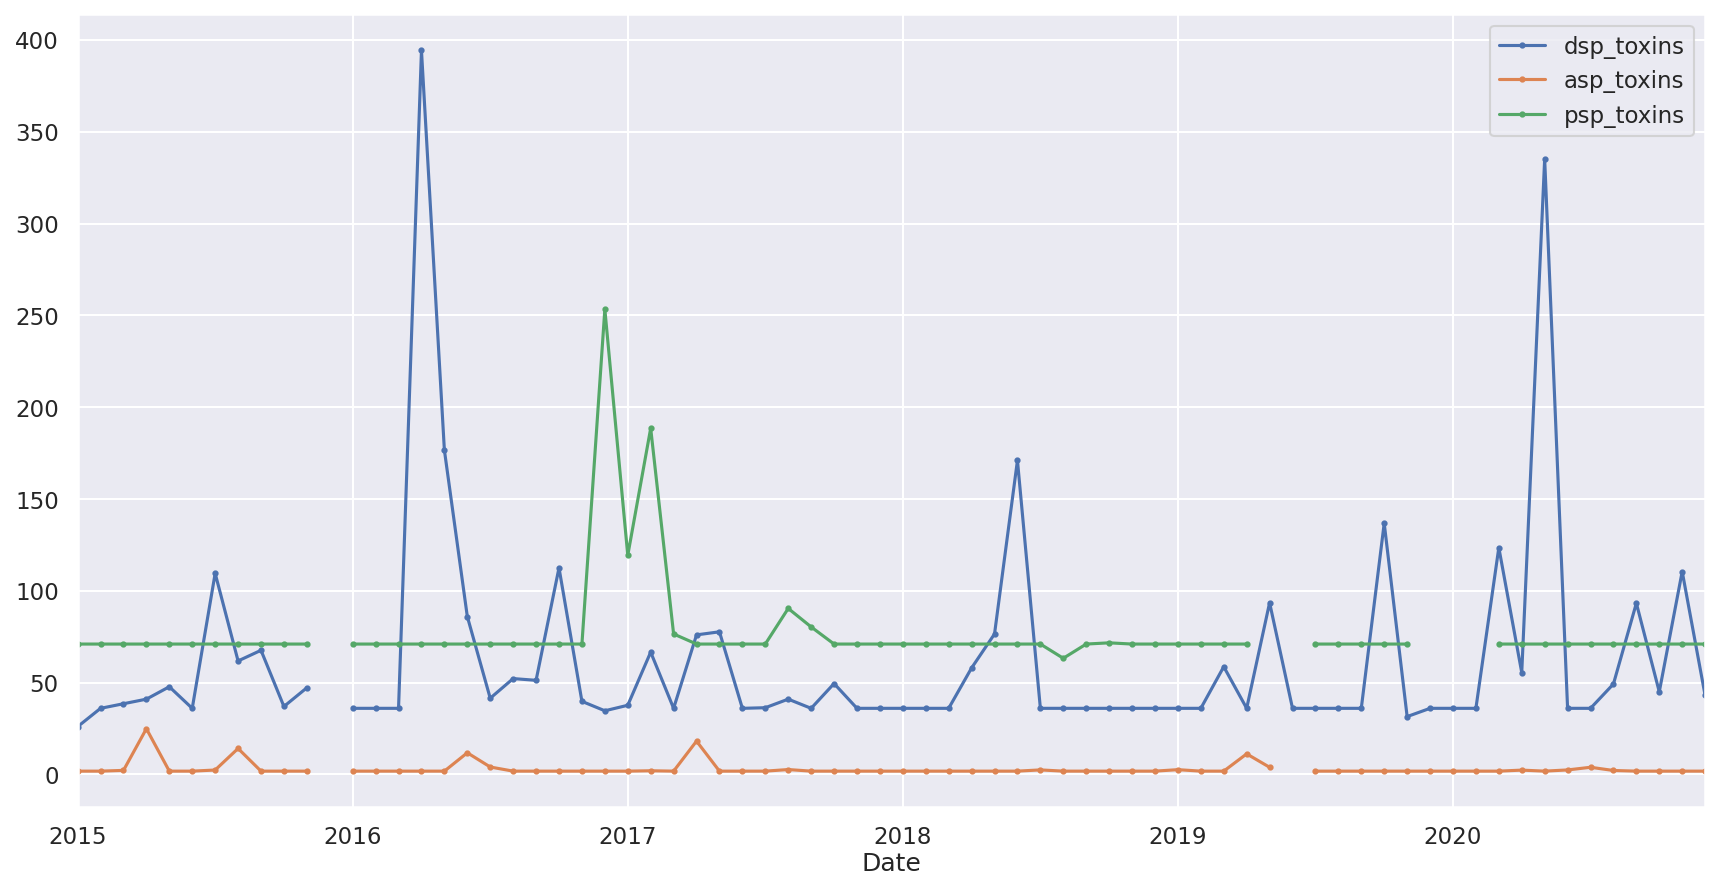

In [21]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Amêijoa-branca", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Amêijoa-branca", "dsp_toxins", "M")

## Compare species

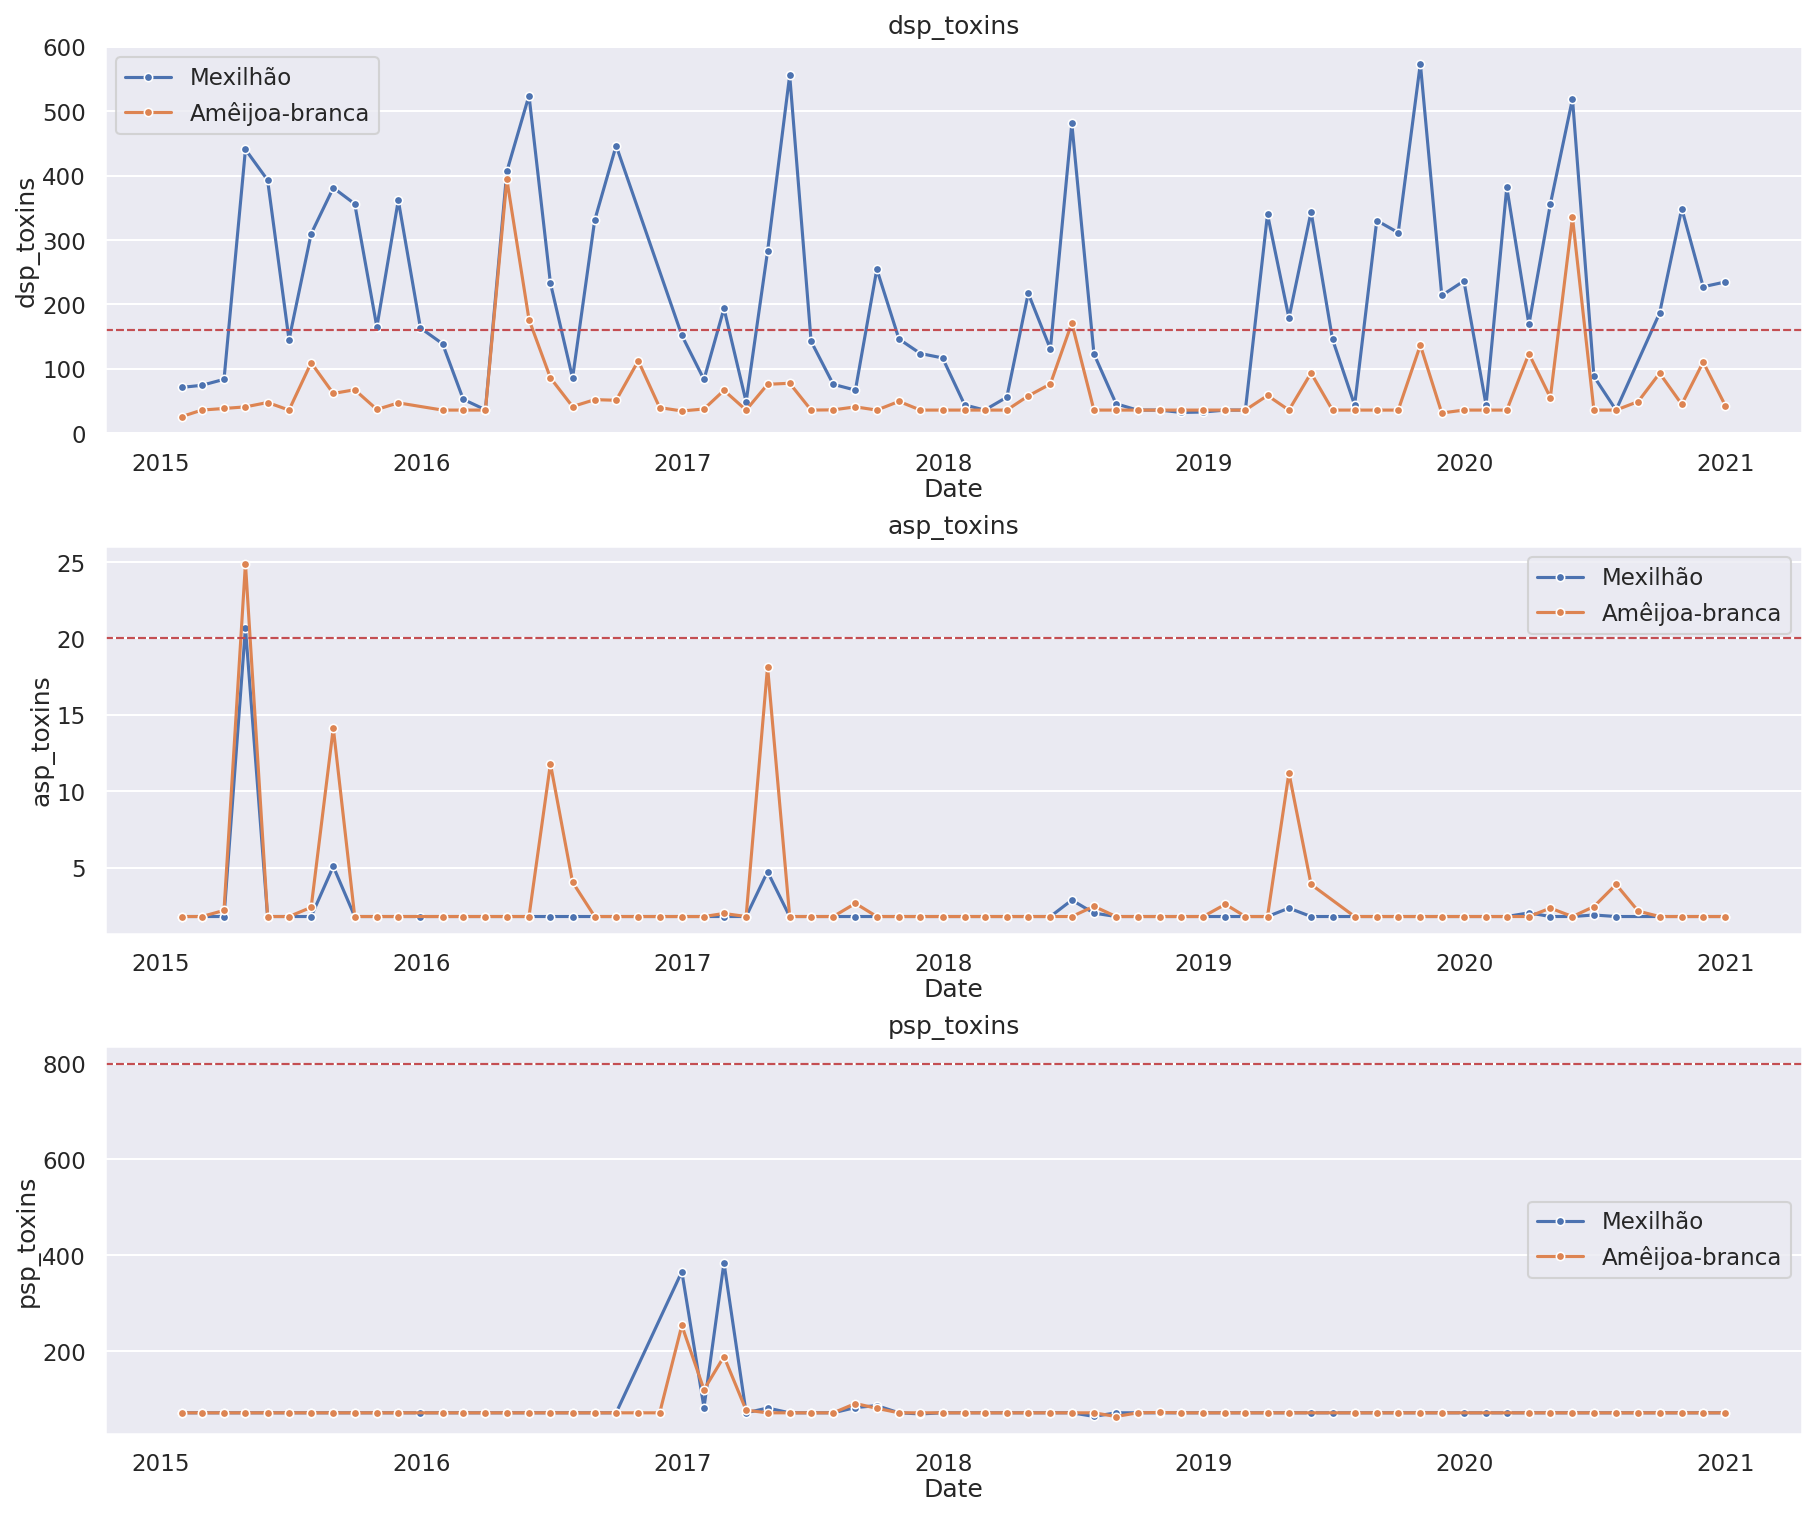

In [22]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

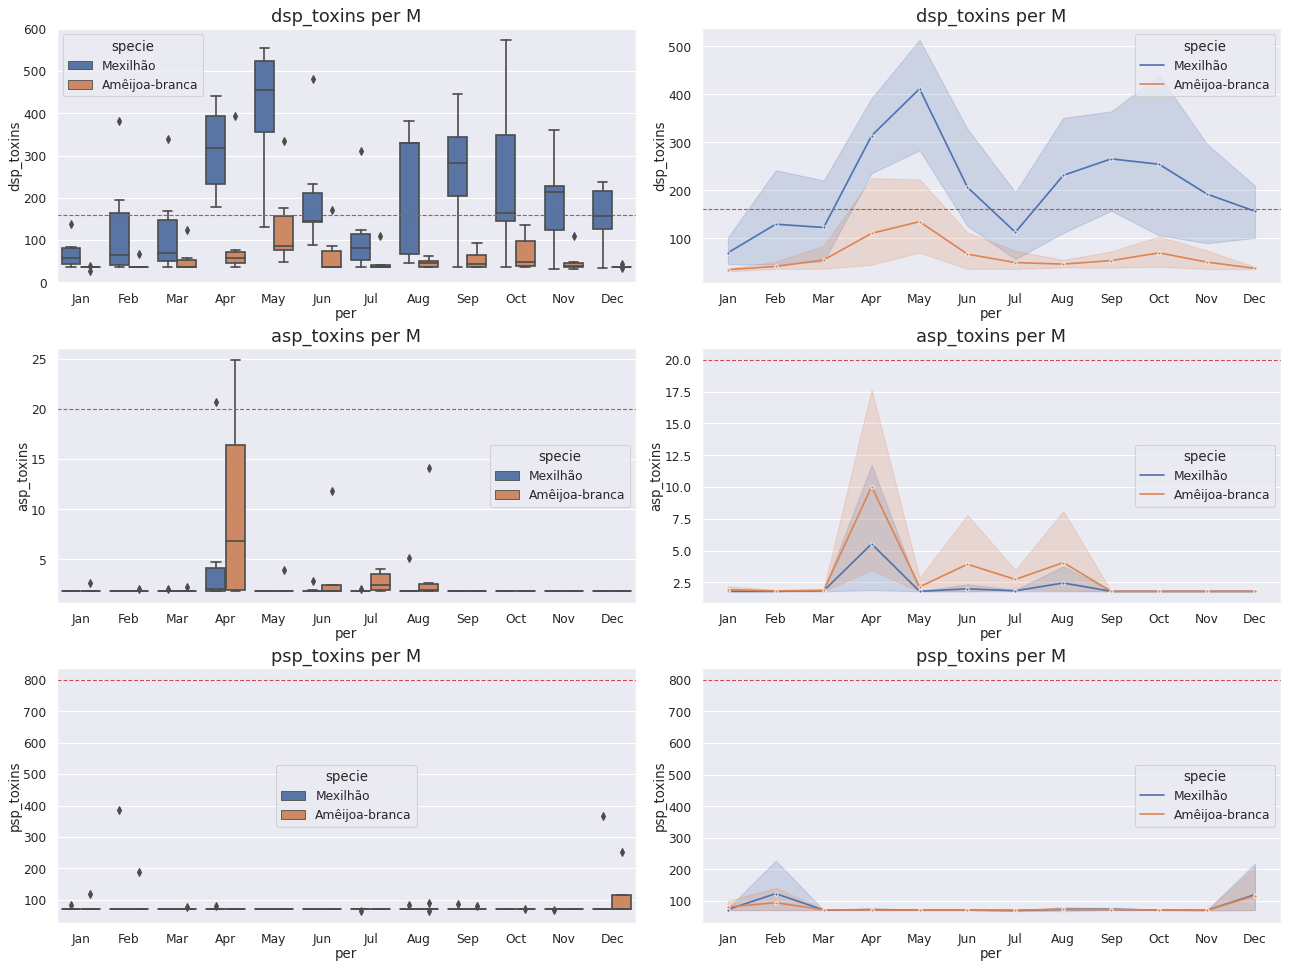

In [23]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

## Trend

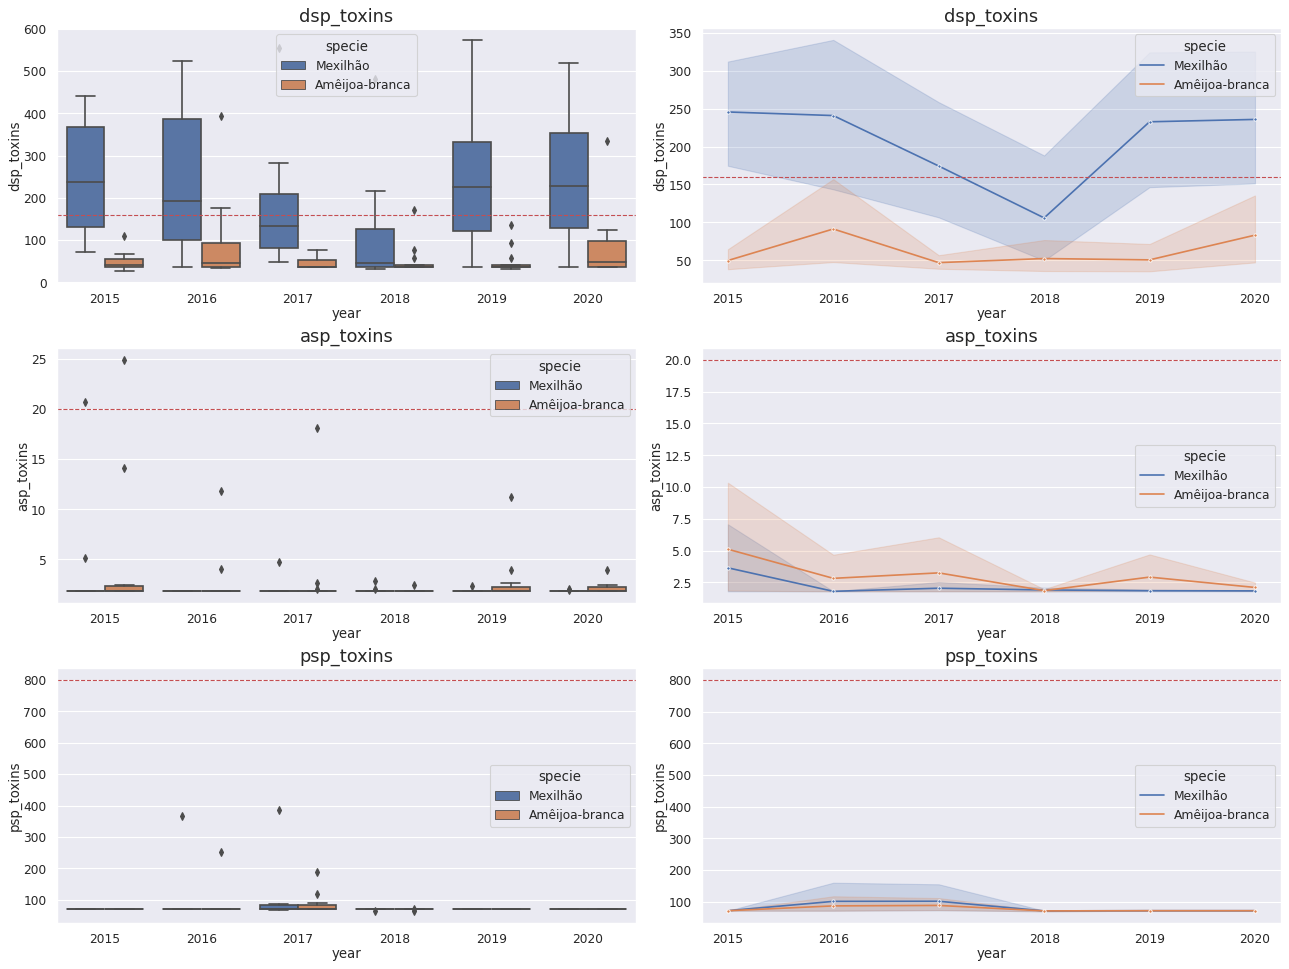

In [24]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()

# LOB

In [12]:
area = "LOB"
species = ["Mexilhão", "Berbigão"]
biotoxins[ (biotoxins["Production_Area"]==area)]["Species"].value_counts()

Berbigão            292
Mexilhão            289
Amêijoa-japonesa     38
Amêijoa-boa          19
Amêijoa-macha        17
Longueirão           13
Amêijoa-branca        1
Name: Species, dtype: int64

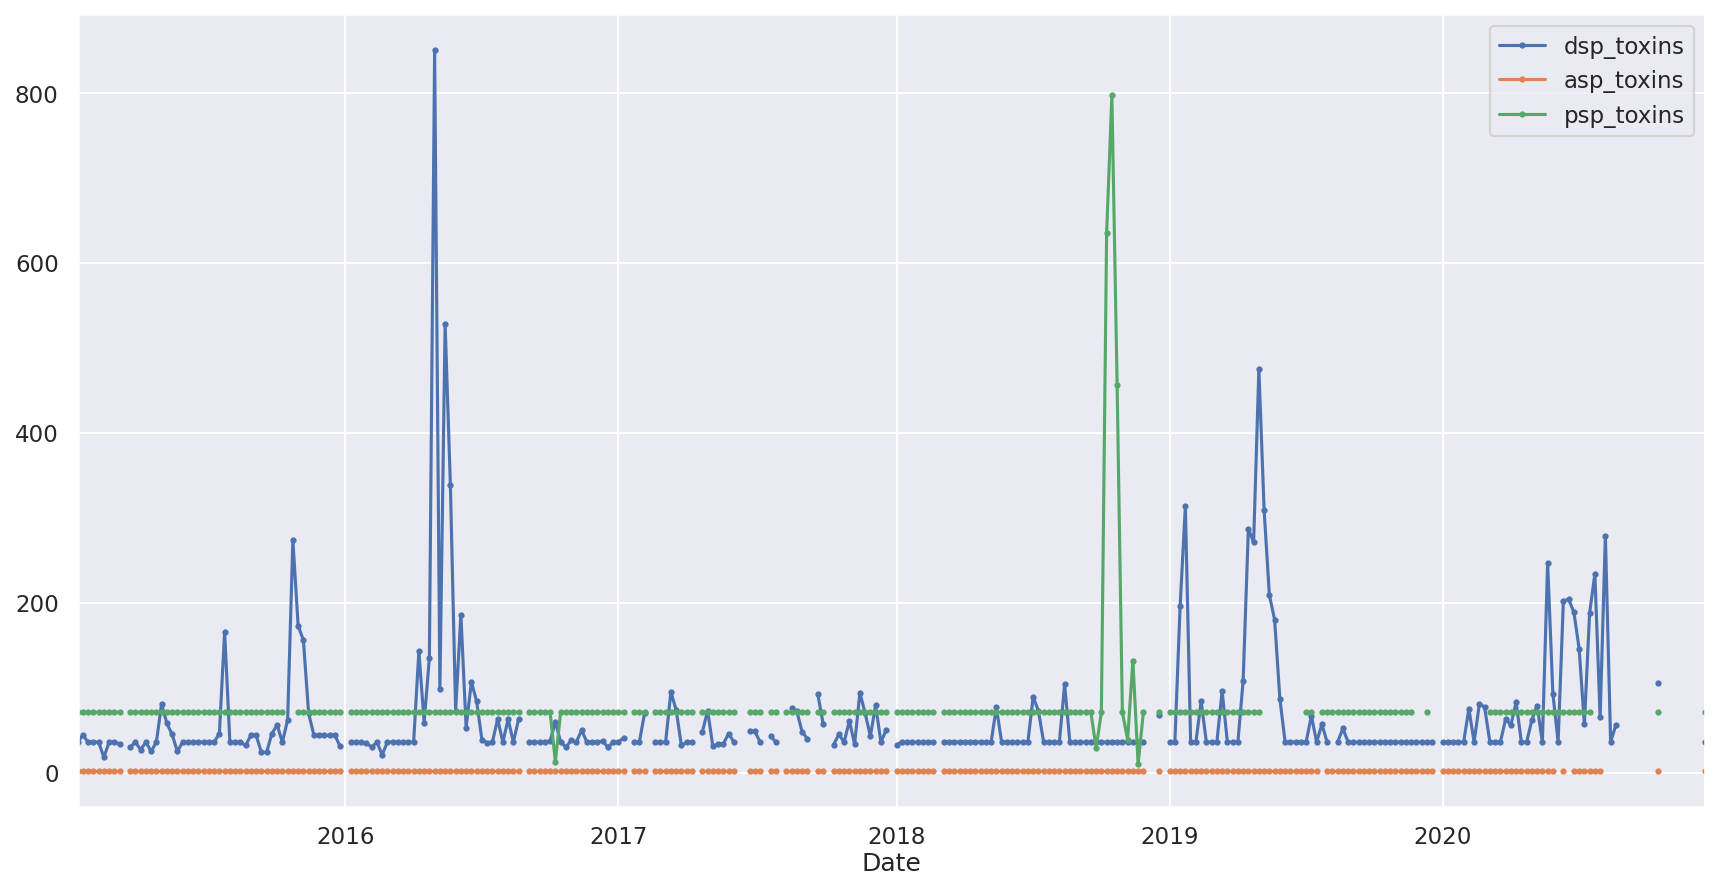

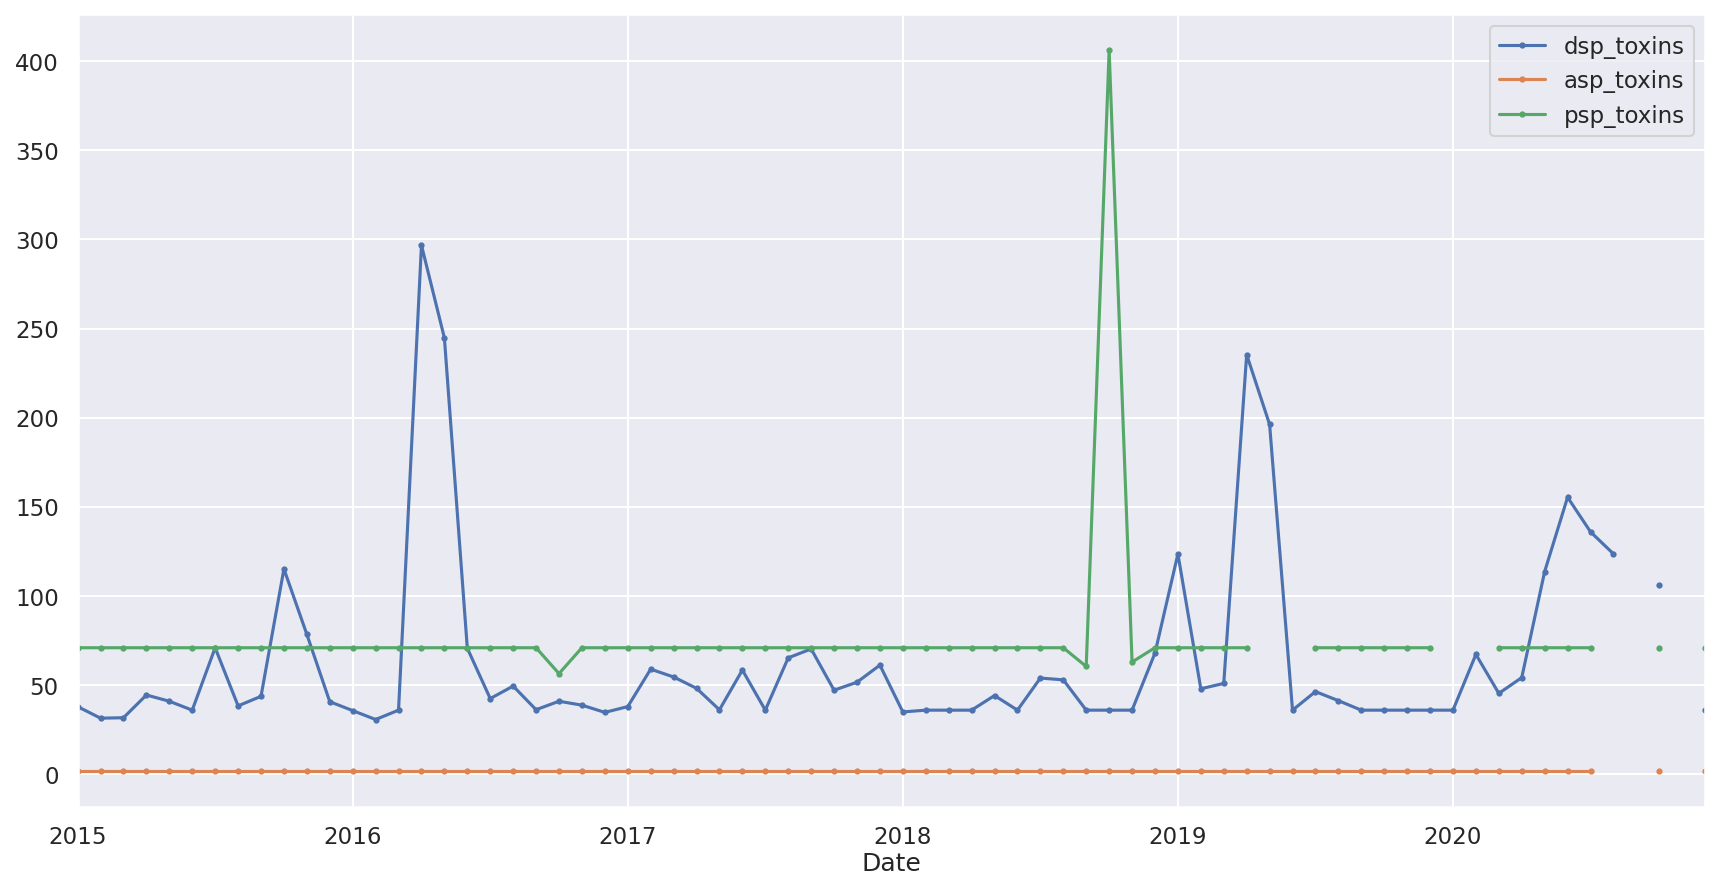

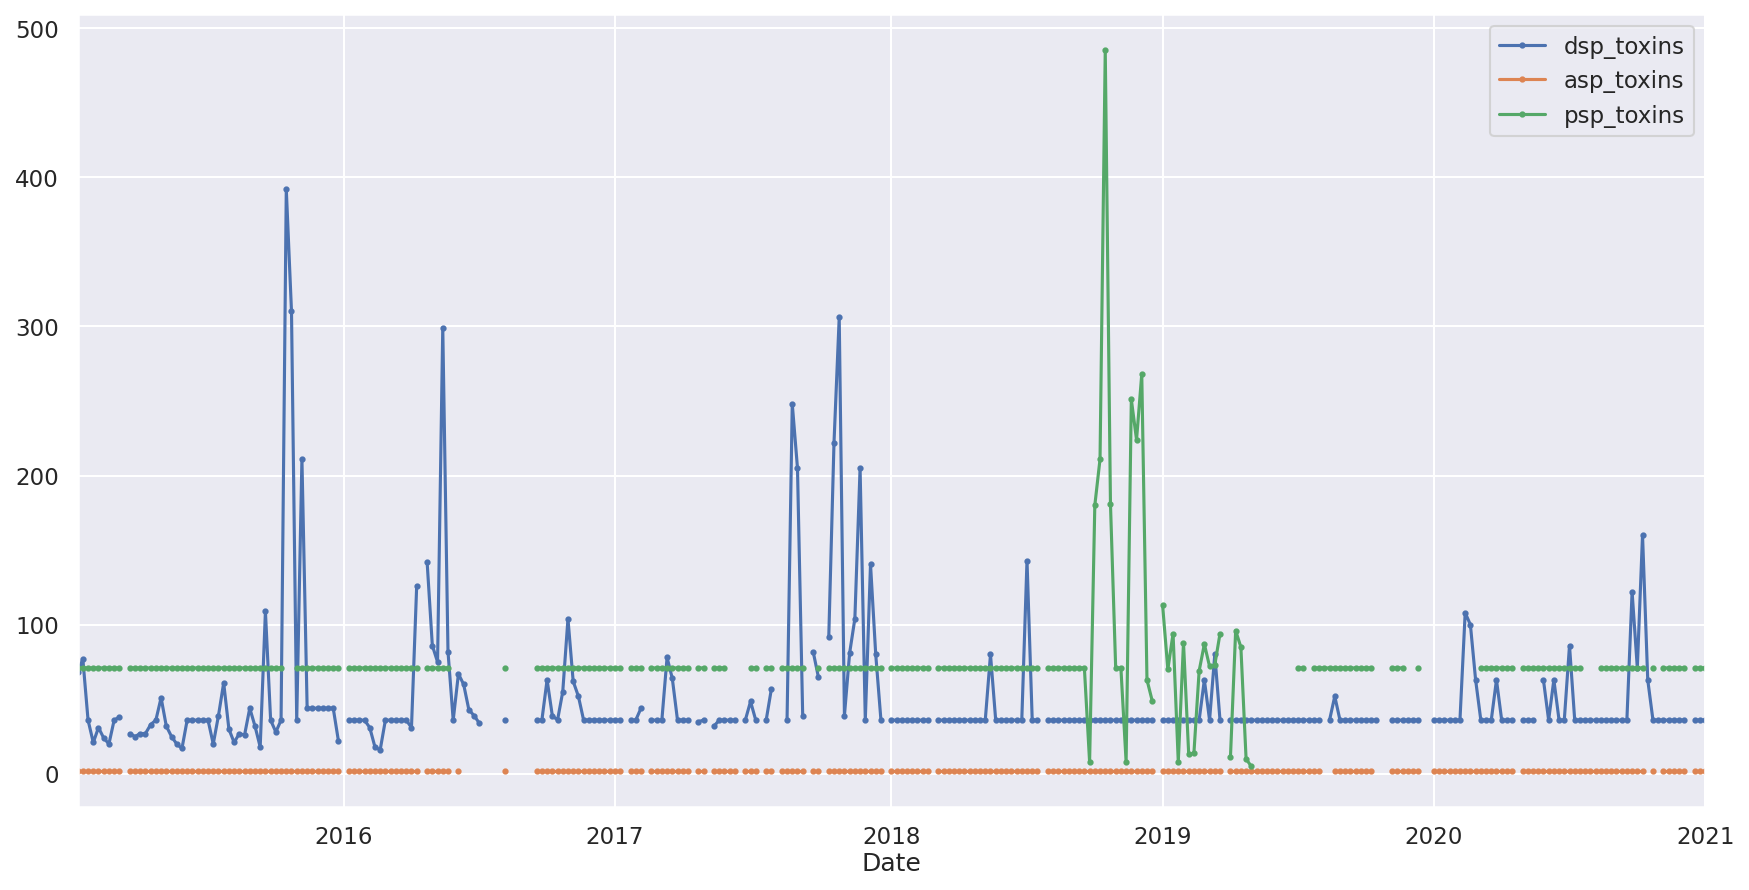

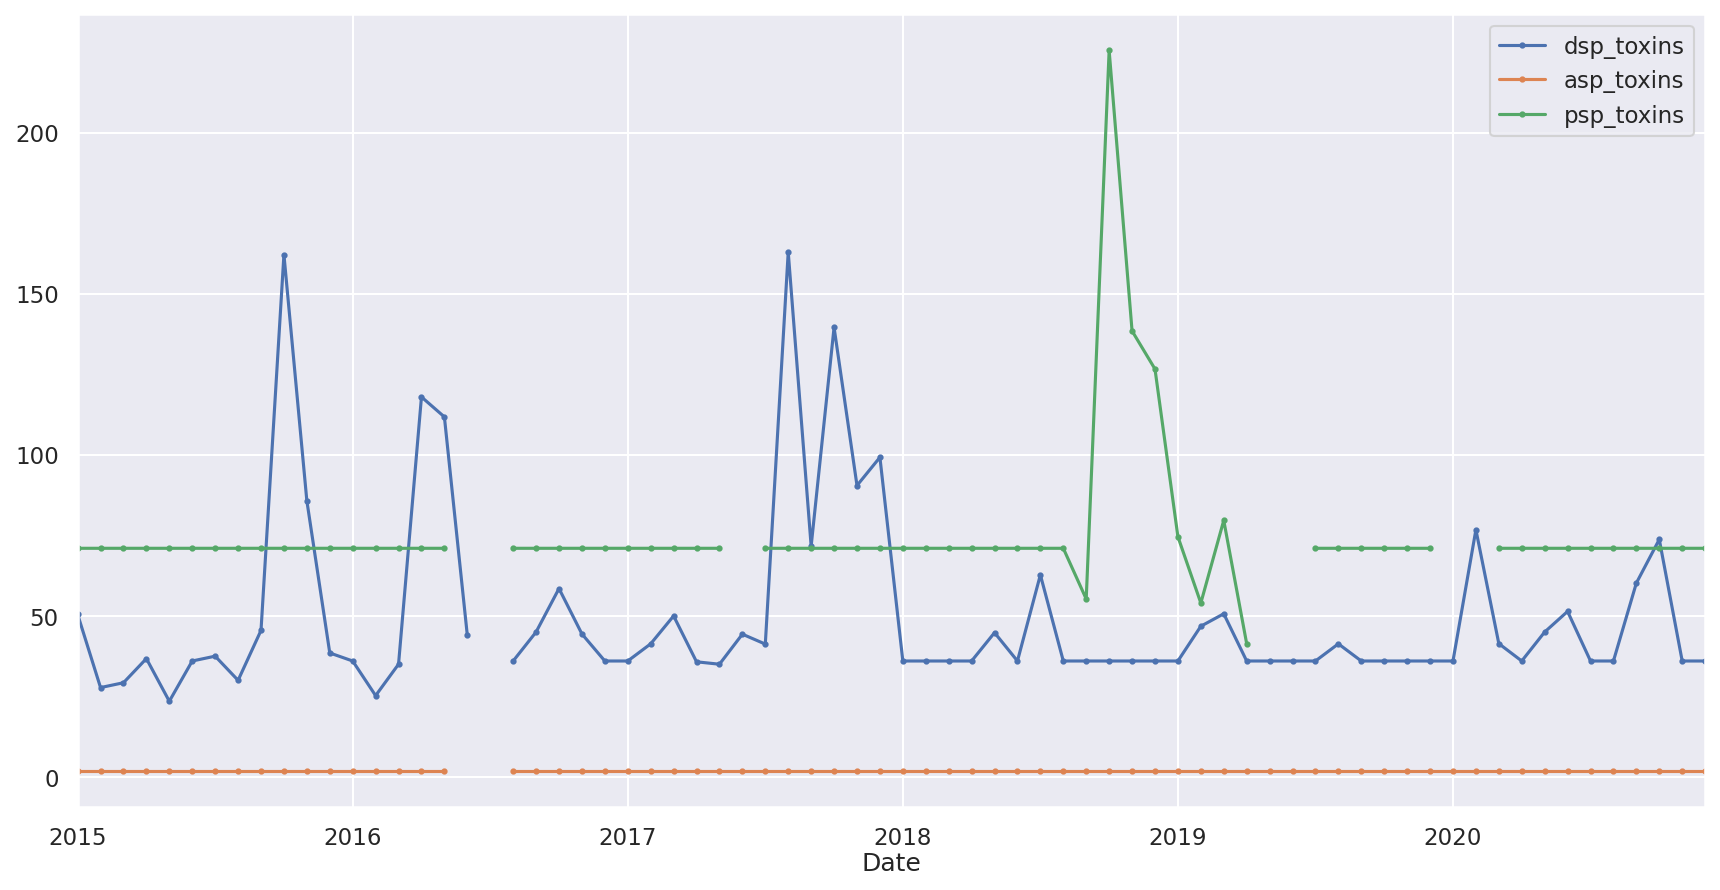

In [13]:
ts_week_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "W")
ts_month_m = get_ts(biotoxins_ts, area, "Mexilhão", "dsp_toxins", "M")

ts_week_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "W")
ts_month_b = get_ts(biotoxins_ts, area, "Berbigão", "dsp_toxins", "M")

## Compare species

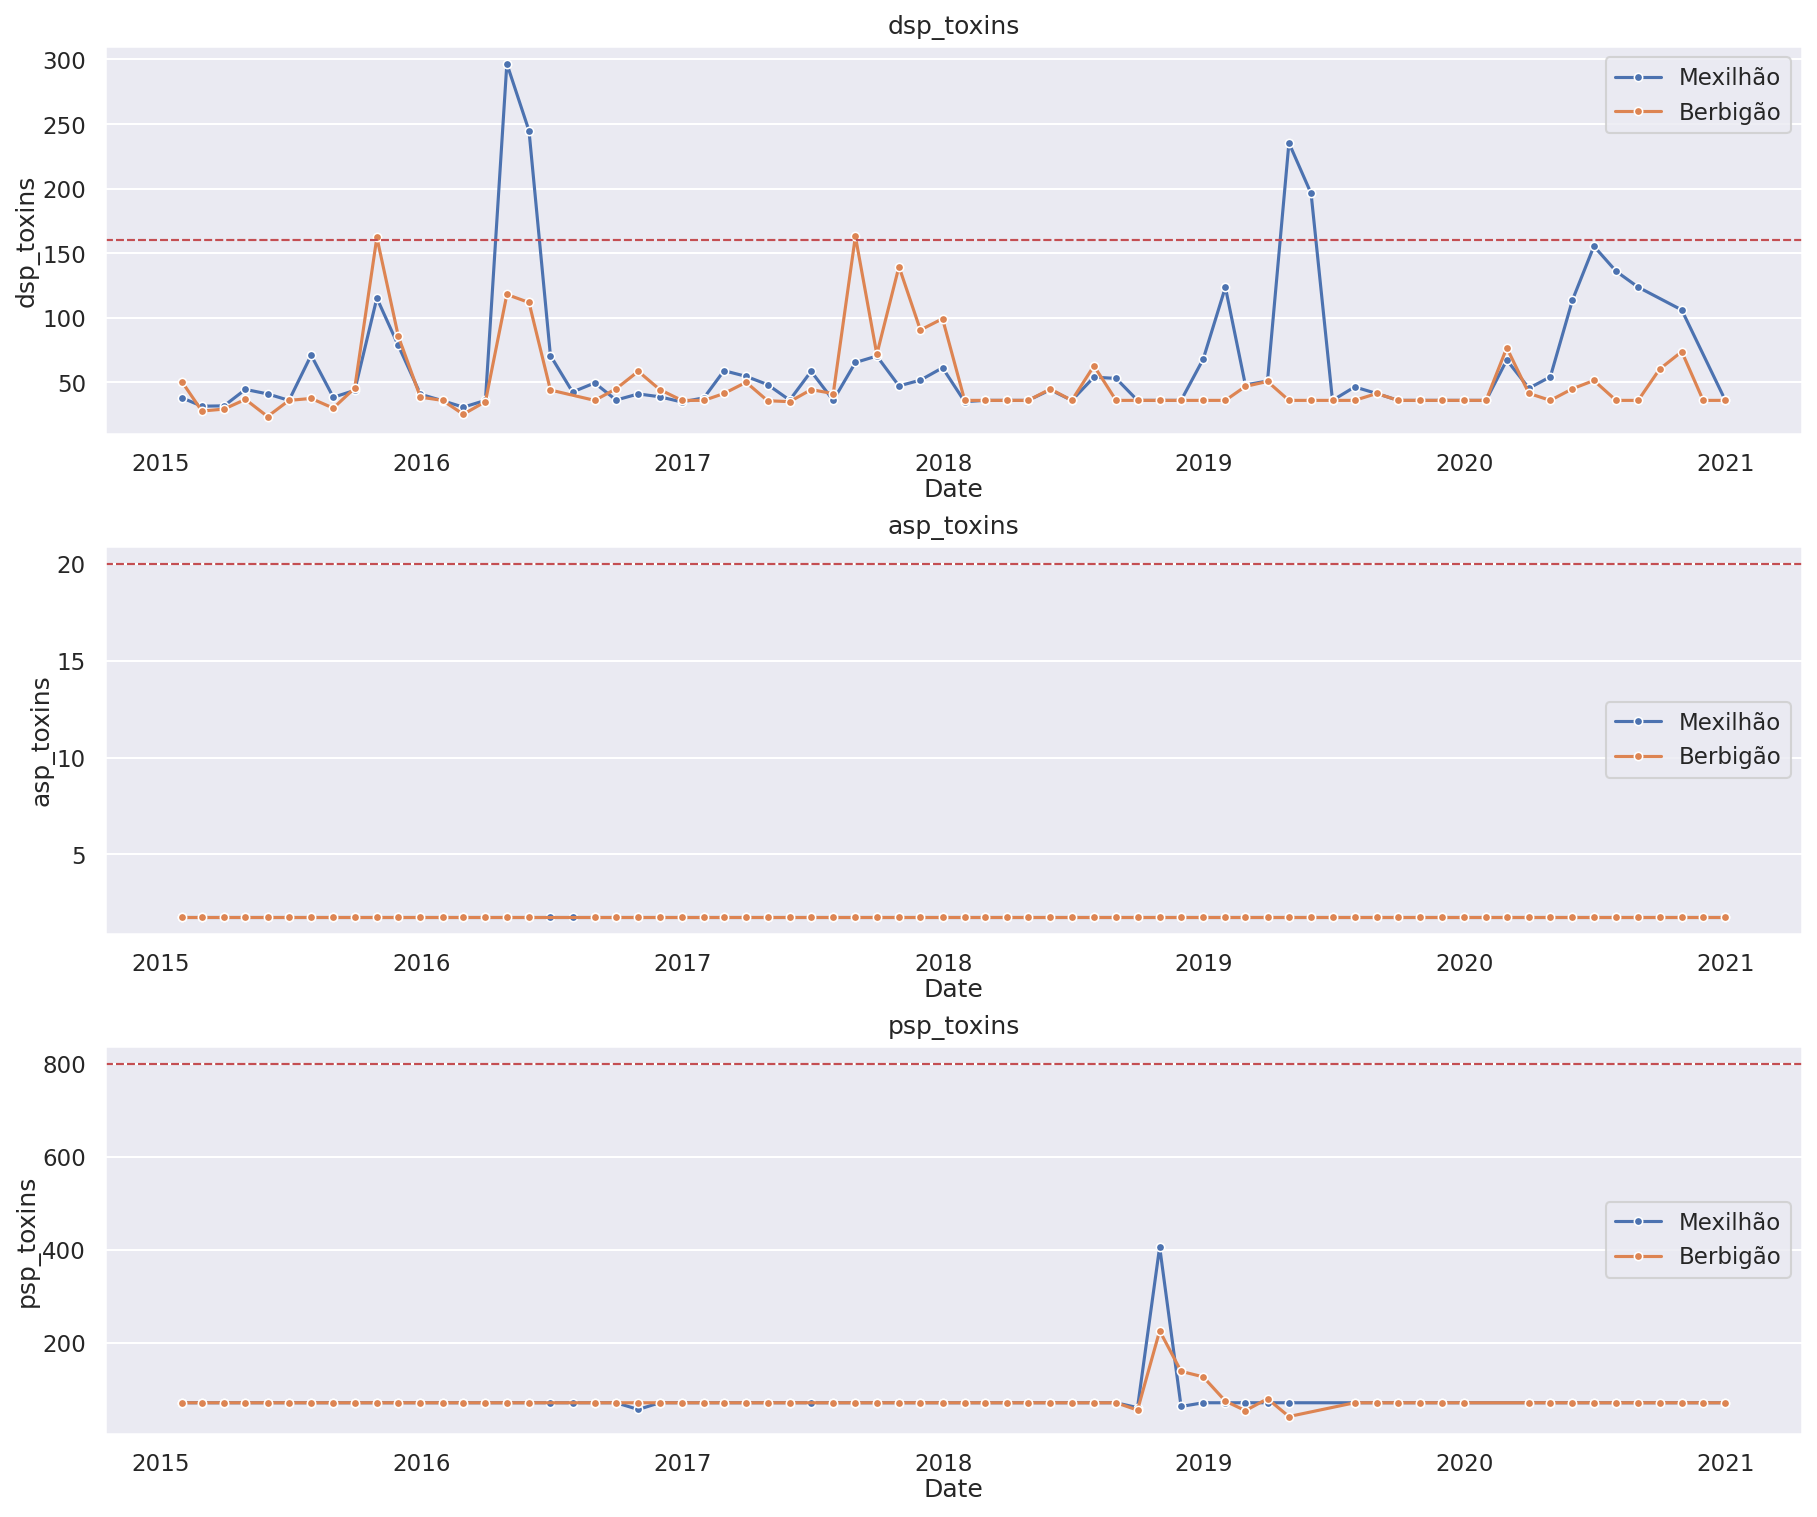

In [14]:
by="M"
    
fig, ax = plt.subplots(3,1, figsize=(12,10), constrained_layout=True)
ax[0] = compare_species_toxicity(biotoxins_ts, area, species, "dsp_toxins", by, ax[0], 160)
ax[1] = compare_species_toxicity(biotoxins_ts, area, species, "asp_toxins", by, ax[1], 20)
ax[2] = compare_species_toxicity(biotoxins_ts, area, species, "psp_toxins", by, ax[2], 800)

plt.show()

## Seasonality

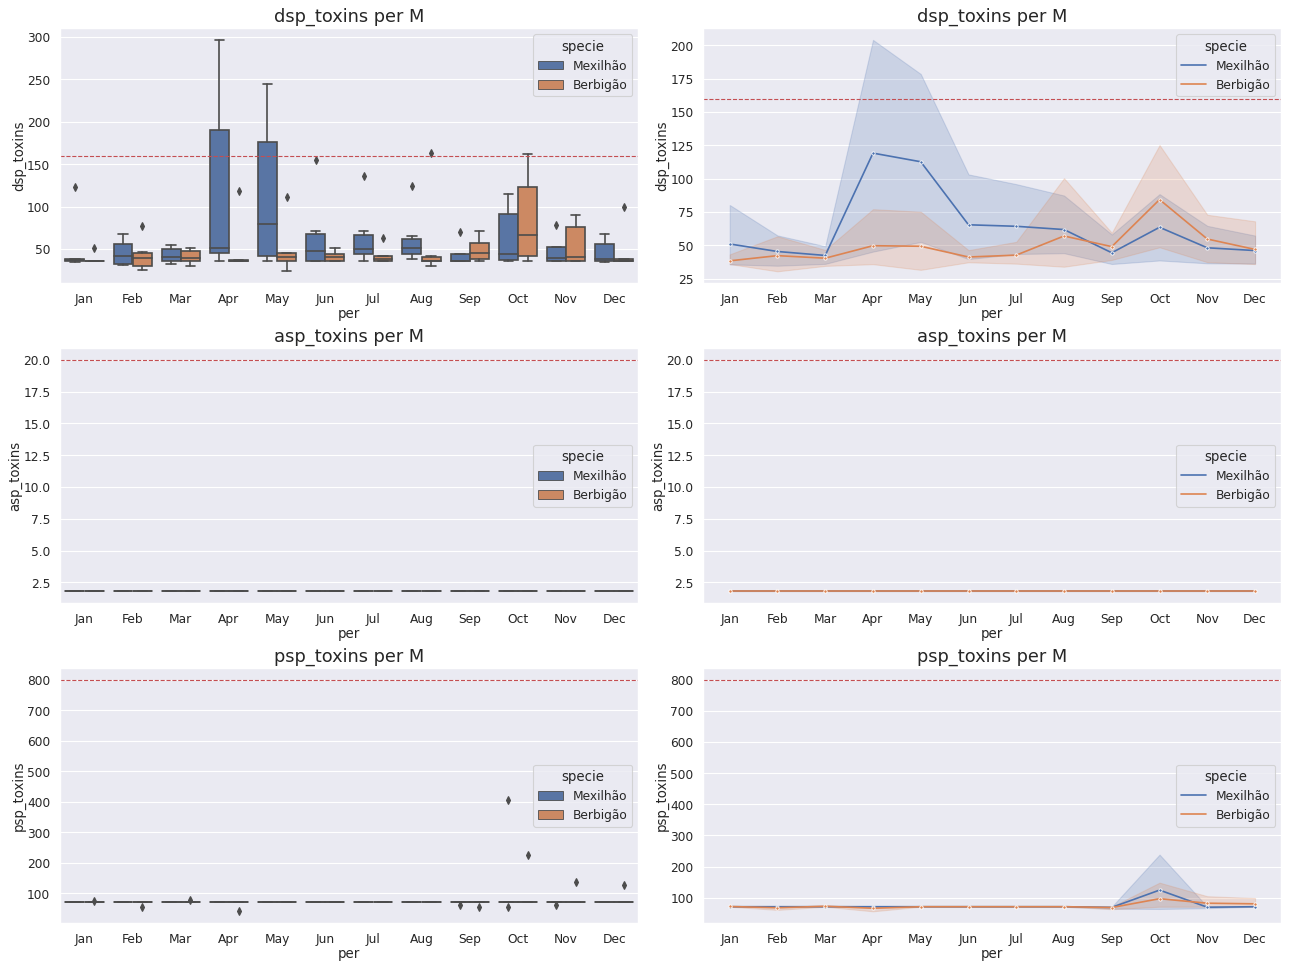

In [15]:
by="M"
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_seasonality(biotoxins_ts, area, species, "dsp_toxins", by, ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_seasonality(biotoxins_ts, area, species, "asp_toxins", by, ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_seasonality(biotoxins_ts, area, species, "psp_toxins", by, ax[2][1], 800,"lineplot")

plt.show()

## Trend

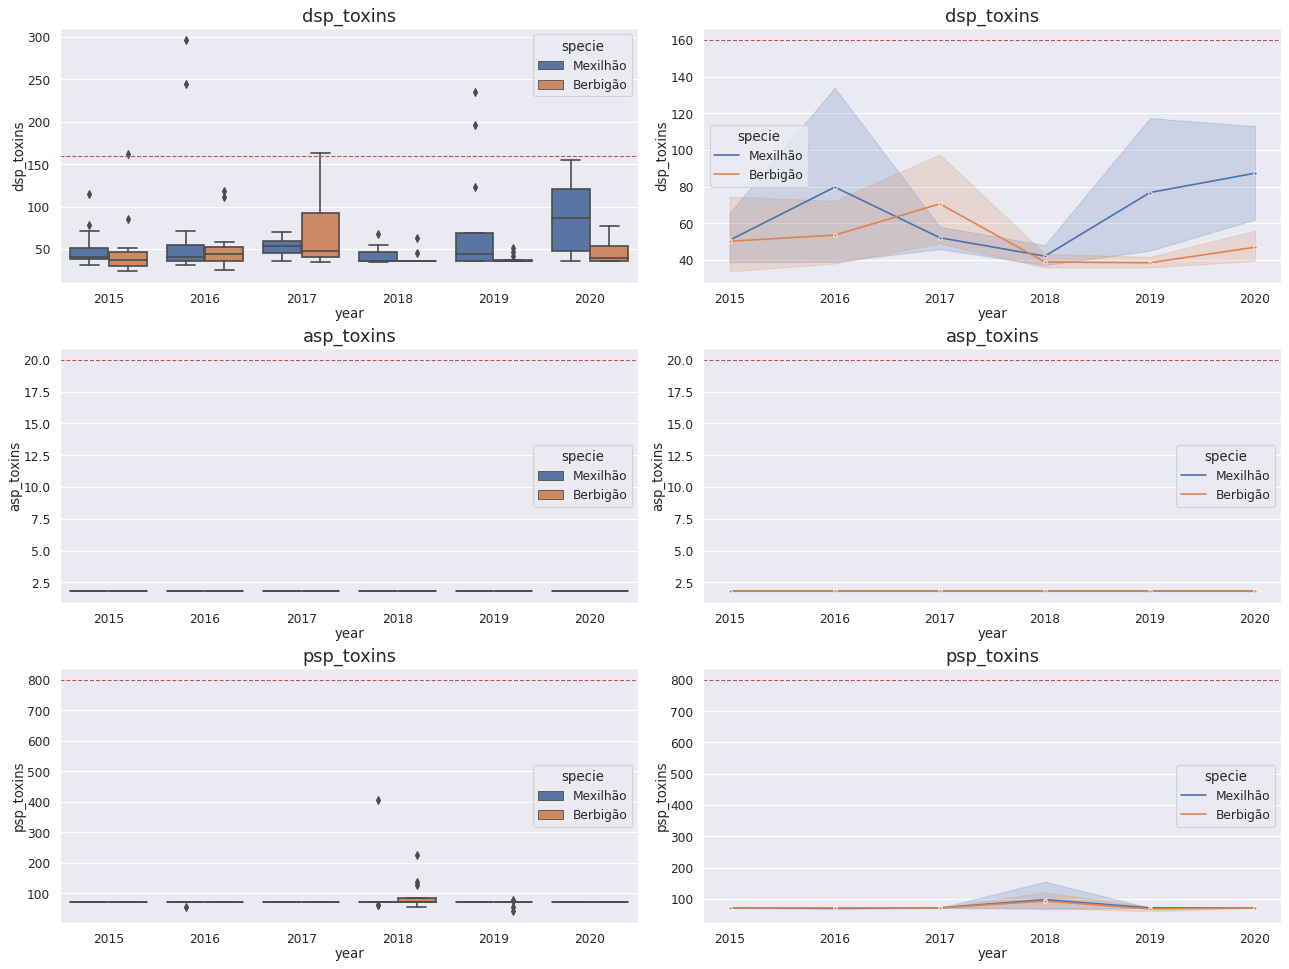

In [16]:
fig, ax = plt.subplots(3,2, figsize=(16,12), constrained_layout=True, dpi=80)

ax[0][0] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][0], 160,"boxplot")
ax[1][0] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][0], 20, "boxplot")
ax[2][0] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][0], 800, "boxplot")

ax[0][1] = compare_species_trend(biotoxins_ts, area, species, "dsp_toxins", ax[0][1], 160,"lineplot")
ax[1][1] = compare_species_trend(biotoxins_ts, area, species, "asp_toxins", ax[1][1], 20, "lineplot")
ax[2][1] = compare_species_trend(biotoxins_ts, area, species, "psp_toxins", ax[2][1], 800,"lineplot")

plt.show()